### EDA 1st Draft
### Capstone: Predicting Solar Energy Demand
#### Robert Manriquez

In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

%matplotlib inline

sns.set_style('darkgrid')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def TimeStampMaker(input_df):
    input_df['Timestamp'] = input_df['Year'].astype(str) + "-" + input_df['Month'].astype(str) + "-" + input_df['Day'].astype(str) +" "\
                                                        + input_df['Hour'].astype(str)+ ":" + input_df['Minute'].astype(str)
    
    input_df['Timestamp'] = pd.to_datetime([input_df['Timestamp']])
    input_df.set_index('Timestamp', inplace = True)    
    
def TimeSeriesFeatures(input_df):
    
#     input_df = pd.read_csv('./SM_PSM_allyears/83160_34.01_-118.46_2013.csv', header = 2)
    
    input_df = input_df.loc[input_df['Minute'] == 0,:].copy()
    
    input_df['Timestamp'] = input_df['Year'].astype(str) + "-" + input_df['Month'].astype(str) + "-" + input_df['Day'].astype(str) +" "\
                                        + input_df['Hour'].astype(str)+ ":" + input_df['Minute'].astype(str)
    
    input_df['Timestamp'] = pd.to_datetime(input_df['Timestamp'])
    input_df.set_index('Timestamp', inplace = True)
    input_df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis =1,inplace = True)
    
    return input_df
# TimeStampMaker(df_2013)    

def PSMTrainingSetMaker(target_year, input_year_list):

    target_df = pd.read_csv('./83160_34.01_-118.46_' +str(target_year) + '.csv',header = 2)
    
    TimeSeriesFeatures(target_df)
    
    target_df[str(target_year) + '_DNI'] = target_df['DNI'].copy()

    loop_df = target_df.loc[:,[str(target_year) + '_DNI']].copy()
    
    for year in input_year_list:
        
        new_df = pd.read_csv('./83160_34.01_-118.46_' +str(year) + '.csv',header = 2)
        
        new_df = TimeStampMaker(new_df).copy()
        
        new_df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis =1,inplace = True )
    
        new_df['Cloud Type'].fillna(10, inplace = True)  # 10 is the value for "unknown"
        new_df = pd.get_dummies(new_df, columns = ['Cloud Type'])
        
        new_df.columns = [str(year) + "_" + col for col in new_df.columns]
#         print(new_df.columns)
        loop_df = pd.merge(left = loop_df, right = new_df, how = 'right', left_index = True, right_index = True)
        
    return loop_df

In [4]:
## Only looking at 1-hour intervals.

In [5]:
df_2013 = pd.read_csv('./83160_34.01_-118.46_2013.csv', header = 2)

df_2013 = TimeSeriesFeatures(df_2013).copy()

In [6]:
df_2013.head()

,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Solar Zenith Angle,Fill Flag,Surface Albedo,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure
Timestamp,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0,0,0,0,0,0,7.0,-1,168.95,0,0.12456,1.1,1.012,156.8,54.18,7,1010.0
2013-01-01 01:00:00,0,0,0,0,0,0,3.0,-2,162.41,0,0.12456,0.9,0.992,161.7,56.23,6,1010.0
2013-01-01 02:00:00,0,0,0,0,0,0,7.0,-2,151.04,0,0.12456,0.7,0.977,167.4,59.31,5,1010.0
2013-01-01 03:00:00,0,0,0,0,0,0,4.0,-2,138.76,0,0.12456,0.6,0.988,187.8,62.88,4,1010.0
2013-01-01 04:00:00,0,0,0,0,0,0,4.0,-2,126.34,0,0.12456,0.6,1.004,215.3,62.31,4,1010.0


In [7]:
def DataPrep(input_df, var, n_lags):
    
    output_df = input_df[[str(var)]].copy()
    
    for i in range(1,n_lags+1):
        output_df[str(var) + '-' + str(i)] = input_df[[str(var)]].shift(i)
        print(i)
    
    return output_df.dropna()



In [8]:
lag = (12)
X = DataPrep(df_2013, 'DNI', n_lags = lag).drop('DNI', axis =1)
y = DataPrep(df_2013, 'DNI', n_lags = lag)['DNI']

1
2
3
4
5
6
7
8
9
10
11
12
1
2
3
4
5
6
7
8
9
10
11
12


In [9]:
X.shape[0]/2, y.shape

(4374.0, (8748,))

In [10]:
X_train = X[:int(X.shape[0]/2)].values.reshape(-1,lag,1)
y_train = y[:int(y.shape[0]/2)].values.reshape(-1,1)

X_test = X[int(X.shape[0]/2):].values.reshape(-1,lag,1)
y_test = y[int(y.shape[0]/2):].values.reshape(-1,1)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_train.shape

((4374, 12, 1), (4374, 1), (4374, 12, 1), (4374, 1))

In [12]:
batch_size = 243

model = Sequential()

model.add(LSTM(100, batch_input_shape=(batch_size, lag, 1),return_sequences = True, stateful = True))
model.add(LSTM(100, batch_input_shape=(batch_size, lag, 1), stateful = True))
model.add(Dense(1))

model.compile(loss= "mean_squared_error", optimizer = 'adam')

for i in range(2000):
    model.fit(X_train, y_train, epochs = 1, batch_size = batch_size, verbose = 2, shuffle=False)
    model.reset_states()

Epoch 1/1
 - 2s - loss: 213617.2201
Epoch 1/1
 - 0s - loss: 209122.7244
Epoch 1/1
 - 0s - loss: 207674.9983
Epoch 1/1
 - 0s - loss: 206613.5859
Epoch 1/1
 - 0s - loss: 205608.0208
Epoch 1/1
 - 0s - loss: 204641.3932
Epoch 1/1
 - 0s - loss: 203703.7899
Epoch 1/1
 - 0s - loss: 202788.2300
Epoch 1/1
 - 0s - loss: 201891.4618
Epoch 1/1
 - 0s - loss: 201011.0013
Epoch 1/1
 - 0s - loss: 200145.0269
Epoch 1/1
 - 0s - loss: 199292.1840
Epoch 1/1
 - 0s - loss: 198451.6610
Epoch 1/1
 - 0s - loss: 197622.7513
Epoch 1/1
 - 0s - loss: 196804.7999
Epoch 1/1
 - 0s - loss: 195997.3633
Epoch 1/1
 - 0s - loss: 195200.1107
Epoch 1/1
 - 0s - loss: 194412.7405
Epoch 1/1
 - 0s - loss: 193635.0269
Epoch 1/1
 - 0s - loss: 192866.6272
Epoch 1/1
 - 0s - loss: 192107.4935
Epoch 1/1
 - 0s - loss: 191357.2062
Epoch 1/1
 - 0s - loss: 190615.7044
Epoch 1/1
 - 0s - loss: 189882.8255
Epoch 1/1
 - 0s - loss: 189158.3780
Epoch 1/1
 - 0s - loss: 188442.2921
Epoch 1/1
 - 0s - loss: 187734.4297
Epoch 1/1
 - 0s - loss: 1870

Epoch 1/1
 - 0s - loss: 80495.7120
Epoch 1/1
 - 0s - loss: 78283.4308
Epoch 1/1
 - 0s - loss: 78248.9323
Epoch 1/1
 - 0s - loss: 78431.6769
Epoch 1/1
 - 0s - loss: 79307.9191
Epoch 1/1
 - 0s - loss: 76558.4284
Epoch 1/1
 - 0s - loss: 75437.1437
Epoch 1/1
 - 0s - loss: 75029.7802
Epoch 1/1
 - 0s - loss: 74767.8494
Epoch 1/1
 - 0s - loss: 74359.3932
Epoch 1/1
 - 0s - loss: 73199.3077
Epoch 1/1
 - 0s - loss: 73385.4993
Epoch 1/1
 - 0s - loss: 72806.0653
Epoch 1/1
 - 0s - loss: 72365.4592
Epoch 1/1
 - 0s - loss: 72181.8683
Epoch 1/1
 - 0s - loss: 71545.0117
Epoch 1/1
 - 0s - loss: 71963.2528
Epoch 1/1
 - 0s - loss: 72542.7493
Epoch 1/1
 - 0s - loss: 71198.8919
Epoch 1/1
 - 0s - loss: 70069.1181
Epoch 1/1
 - 0s - loss: 69831.1491
Epoch 1/1
 - 0s - loss: 69807.8016
Epoch 1/1
 - 0s - loss: 70377.1855
Epoch 1/1
 - 0s - loss: 71480.3969
Epoch 1/1
 - 0s - loss: 70720.4913
Epoch 1/1
 - 0s - loss: 70232.2862
Epoch 1/1
 - 0s - loss: 69510.0681
Epoch 1/1
 - 0s - loss: 69530.9835
Epoch 1/1
 - 0s - lo

 - 0s - loss: 24906.6684
Epoch 1/1
 - 0s - loss: 23034.2380
Epoch 1/1
 - 0s - loss: 21541.4316
Epoch 1/1
 - 0s - loss: 21863.1615
Epoch 1/1
 - 0s - loss: 24038.9140
Epoch 1/1
 - 0s - loss: 22287.9215
Epoch 1/1
 - 0s - loss: 22325.3407
Epoch 1/1
 - 0s - loss: 20931.9384
Epoch 1/1
 - 0s - loss: 21656.6749
Epoch 1/1
 - 0s - loss: 20451.4903
Epoch 1/1
 - 0s - loss: 19697.0223
Epoch 1/1
 - 0s - loss: 19670.9303
Epoch 1/1
 - 0s - loss: 19278.1935
Epoch 1/1
 - 0s - loss: 19657.8880
Epoch 1/1
 - 0s - loss: 20023.5411
Epoch 1/1
 - 0s - loss: 20346.8949
Epoch 1/1
 - 0s - loss: 19540.5071
Epoch 1/1
 - 0s - loss: 20676.3252
Epoch 1/1
 - 0s - loss: 21971.5064
Epoch 1/1
 - 0s - loss: 21490.4307
Epoch 1/1
 - 0s - loss: 19516.1286
Epoch 1/1
 - 0s - loss: 19424.7746
Epoch 1/1
 - 0s - loss: 19255.8038
Epoch 1/1
 - 0s - loss: 19223.4088
Epoch 1/1
 - 0s - loss: 19063.9677
Epoch 1/1
 - 0s - loss: 18731.2514
Epoch 1/1
 - 0s - loss: 18485.3543
Epoch 1/1
 - 0s - loss: 17356.6082
Epoch 1/1
 - 0s - loss: 17096.

 - 0s - loss: 9525.8362
Epoch 1/1
 - 0s - loss: 8943.8796
Epoch 1/1
 - 0s - loss: 8641.2161
Epoch 1/1
 - 0s - loss: 8802.3518
Epoch 1/1
 - 0s - loss: 8624.2122
Epoch 1/1
 - 0s - loss: 8966.9323
Epoch 1/1
 - 0s - loss: 8598.5603
Epoch 1/1
 - 0s - loss: 9001.6397
Epoch 1/1
 - 0s - loss: 9471.9813
Epoch 1/1
 - 0s - loss: 10155.4126
Epoch 1/1
 - 0s - loss: 9238.6662
Epoch 1/1
 - 0s - loss: 8139.1814
Epoch 1/1
 - 0s - loss: 8241.6520
Epoch 1/1
 - 0s - loss: 8397.2305
Epoch 1/1
 - 0s - loss: 8274.1615
Epoch 1/1
 - 0s - loss: 8120.0181
Epoch 1/1
 - 0s - loss: 8431.4297
Epoch 1/1
 - 0s - loss: 9241.4893
Epoch 1/1
 - 0s - loss: 9003.0519
Epoch 1/1
 - 0s - loss: 9847.3673
Epoch 1/1
 - 0s - loss: 10355.8931
Epoch 1/1
 - 0s - loss: 8480.1374
Epoch 1/1
 - 0s - loss: 8603.6037
Epoch 1/1
 - 0s - loss: 8444.0119
Epoch 1/1
 - 0s - loss: 8064.9893
Epoch 1/1
 - 0s - loss: 7614.3593
Epoch 1/1
 - 0s - loss: 7536.5601
Epoch 1/1
 - 0s - loss: 7398.2763
Epoch 1/1
 - 0s - loss: 7523.0788
Epoch 1/1
 - 0s - loss

Epoch 1/1
 - 0s - loss: 6354.9067
Epoch 1/1
 - 0s - loss: 6120.5430
Epoch 1/1
 - 0s - loss: 5416.1051
Epoch 1/1
 - 0s - loss: 5221.3343
Epoch 1/1
 - 0s - loss: 5615.3483
Epoch 1/1
 - 0s - loss: 5194.9263
Epoch 1/1
 - 0s - loss: 5777.8304
Epoch 1/1
 - 0s - loss: 5539.2021
Epoch 1/1
 - 0s - loss: 5779.6410
Epoch 1/1
 - 0s - loss: 4919.6768
Epoch 1/1
 - 0s - loss: 5276.9762
Epoch 1/1
 - 0s - loss: 4578.0883
Epoch 1/1
 - 0s - loss: 4769.2943
Epoch 1/1
 - 0s - loss: 4660.3309
Epoch 1/1
 - 0s - loss: 4501.8943
Epoch 1/1
 - 0s - loss: 4814.6772
Epoch 1/1
 - 0s - loss: 4899.2437
Epoch 1/1
 - 0s - loss: 5613.5233
Epoch 1/1
 - 0s - loss: 5957.6895
Epoch 1/1
 - 0s - loss: 5795.3016
Epoch 1/1
 - 0s - loss: 7081.9338
Epoch 1/1
 - 0s - loss: 7170.3617
Epoch 1/1
 - 0s - loss: 10646.6433
Epoch 1/1
 - 0s - loss: 7836.7798
Epoch 1/1
 - 0s - loss: 7304.5176
Epoch 1/1
 - 0s - loss: 6568.2845
Epoch 1/1
 - 0s - loss: 7734.0595
Epoch 1/1
 - 0s - loss: 8047.2403
Epoch 1/1
 - 0s - loss: 6779.5222
Epoch 1/1
 - 

Epoch 1/1
 - 0s - loss: 5209.1469
Epoch 1/1
 - 0s - loss: 4485.5872
Epoch 1/1
 - 0s - loss: 4600.6095
Epoch 1/1
 - 0s - loss: 5255.0817
Epoch 1/1
 - 0s - loss: 5604.3494
Epoch 1/1
 - 0s - loss: 5431.5157
Epoch 1/1
 - 0s - loss: 4974.4129
Epoch 1/1
 - 0s - loss: 4416.7104
Epoch 1/1
 - 0s - loss: 4367.6234
Epoch 1/1
 - 0s - loss: 4434.1619
Epoch 1/1
 - 0s - loss: 4629.0669
Epoch 1/1
 - 0s - loss: 4321.9777
Epoch 1/1
 - 0s - loss: 4723.4935
Epoch 1/1
 - 0s - loss: 5406.0687
Epoch 1/1
 - 0s - loss: 6054.6949
Epoch 1/1
 - 0s - loss: 5000.1729
Epoch 1/1
 - 0s - loss: 5194.5035
Epoch 1/1
 - 0s - loss: 5585.0776
Epoch 1/1
 - 0s - loss: 5246.4268
Epoch 1/1
 - 0s - loss: 4670.9414
Epoch 1/1
 - 0s - loss: 5042.5093
Epoch 1/1
 - 0s - loss: 6064.7644
Epoch 1/1
 - 0s - loss: 5980.4889
Epoch 1/1
 - 0s - loss: 7875.1366
Epoch 1/1
 - 0s - loss: 7212.9728
Epoch 1/1
 - 0s - loss: 5755.7087
Epoch 1/1
 - 0s - loss: 5145.6291
Epoch 1/1
 - 0s - loss: 4759.2492
Epoch 1/1
 - 0s - loss: 4765.4901
Epoch 1/1
 - 0

Epoch 1/1
 - 0s - loss: 4630.3873
Epoch 1/1
 - 0s - loss: 4436.9726
Epoch 1/1
 - 0s - loss: 3670.0843
Epoch 1/1
 - 0s - loss: 3252.8653
Epoch 1/1
 - 0s - loss: 3133.0388
Epoch 1/1
 - 0s - loss: 3181.1565
Epoch 1/1
 - 0s - loss: 3923.1150
Epoch 1/1
 - 0s - loss: 4006.1380
Epoch 1/1
 - 0s - loss: 4218.6934
Epoch 1/1
 - 0s - loss: 4040.7350
Epoch 1/1
 - 0s - loss: 3031.0280
Epoch 1/1
 - 0s - loss: 3149.1980
Epoch 1/1
 - 0s - loss: 2946.0986
Epoch 1/1
 - 0s - loss: 3226.2482
Epoch 1/1
 - 0s - loss: 3276.1421
Epoch 1/1
 - 0s - loss: 3266.0402
Epoch 1/1
 - 0s - loss: 3108.8101
Epoch 1/1
 - 0s - loss: 2941.2347
Epoch 1/1
 - 0s - loss: 2584.6200
Epoch 1/1
 - 0s - loss: 2375.4112
Epoch 1/1
 - 0s - loss: 2311.8141
Epoch 1/1
 - 0s - loss: 2306.7440
Epoch 1/1
 - 0s - loss: 2291.8916
Epoch 1/1
 - 0s - loss: 2483.9521
Epoch 1/1
 - 0s - loss: 2867.4709
Epoch 1/1
 - 0s - loss: 3741.8732
Epoch 1/1
 - 0s - loss: 3707.5982
Epoch 1/1
 - 0s - loss: 3742.0547
Epoch 1/1
 - 0s - loss: 4593.7120
Epoch 1/1
 - 0

Epoch 1/1
 - 0s - loss: 1975.5004
Epoch 1/1
 - 0s - loss: 2182.6813
Epoch 1/1
 - 0s - loss: 2668.2994
Epoch 1/1
 - 0s - loss: 3098.7135
Epoch 1/1
 - 0s - loss: 3780.0427
Epoch 1/1
 - 0s - loss: 3817.2189
Epoch 1/1
 - 0s - loss: 3567.0498
Epoch 1/1
 - 0s - loss: 3540.7034
Epoch 1/1
 - 0s - loss: 3098.1773
Epoch 1/1
 - 0s - loss: 3575.8832
Epoch 1/1
 - 0s - loss: 3349.5149
Epoch 1/1
 - 0s - loss: 4204.9885
Epoch 1/1
 - 0s - loss: 3591.4996
Epoch 1/1
 - 0s - loss: 3366.3479
Epoch 1/1
 - 0s - loss: 3715.0499
Epoch 1/1
 - 0s - loss: 3345.5302
Epoch 1/1
 - 0s - loss: 3122.7634
Epoch 1/1
 - 0s - loss: 3511.0421
Epoch 1/1
 - 0s - loss: 3288.3251
Epoch 1/1
 - 0s - loss: 2753.8877
Epoch 1/1
 - 0s - loss: 2323.2576
Epoch 1/1
 - 0s - loss: 2307.1229
Epoch 1/1
 - 0s - loss: 2134.9808
Epoch 1/1
 - 0s - loss: 2397.0261
Epoch 1/1
 - 0s - loss: 2385.5032
Epoch 1/1
 - 0s - loss: 3341.1057
Epoch 1/1
 - 0s - loss: 6045.9634
Epoch 1/1
 - 0s - loss: 4428.8984
Epoch 1/1
 - 0s - loss: 4133.1212
Epoch 1/1
 - 0

Epoch 1/1
 - 0s - loss: 1796.9339
Epoch 1/1
 - 0s - loss: 1731.1526
Epoch 1/1
 - 0s - loss: 1678.7473
Epoch 1/1
 - 0s - loss: 1776.9683
Epoch 1/1
 - 0s - loss: 1878.9357
Epoch 1/1
 - 0s - loss: 1814.7674
Epoch 1/1
 - 0s - loss: 1844.4752
Epoch 1/1
 - 0s - loss: 1843.5108
Epoch 1/1
 - 0s - loss: 1946.8193
Epoch 1/1
 - 0s - loss: 2339.5890
Epoch 1/1
 - 0s - loss: 2694.3192
Epoch 1/1
 - 0s - loss: 2956.0067
Epoch 1/1
 - 0s - loss: 2578.0244
Epoch 1/1
 - 0s - loss: 2486.4507
Epoch 1/1
 - 0s - loss: 2898.3881
Epoch 1/1
 - 0s - loss: 2660.7475
Epoch 1/1
 - 0s - loss: 2993.5741
Epoch 1/1
 - 0s - loss: 3293.4317
Epoch 1/1
 - 0s - loss: 3491.2109
Epoch 1/1
 - 0s - loss: 3494.7890
Epoch 1/1
 - 0s - loss: 3121.8693
Epoch 1/1
 - 0s - loss: 2654.4928
Epoch 1/1
 - 0s - loss: 2643.7171
Epoch 1/1
 - 0s - loss: 2772.0294
Epoch 1/1
 - 0s - loss: 2803.7654
Epoch 1/1
 - 0s - loss: 2352.1715
Epoch 1/1
 - 0s - loss: 2232.3352
Epoch 1/1
 - 0s - loss: 1968.3354
Epoch 1/1
 - 0s - loss: 1826.5287
Epoch 1/1
 - 0

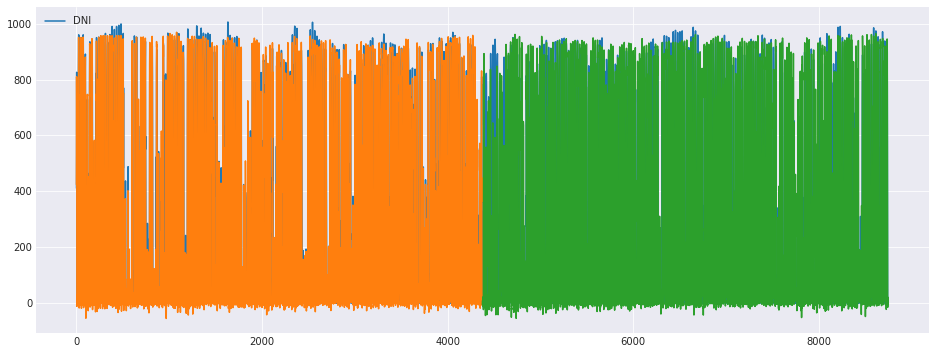

In [13]:
trainPredict = model.predict(X_train,batch_size=batch_size)
model.reset_states()
testPredict = model.predict(X_test,batch_size=batch_size)
model.reset_states()

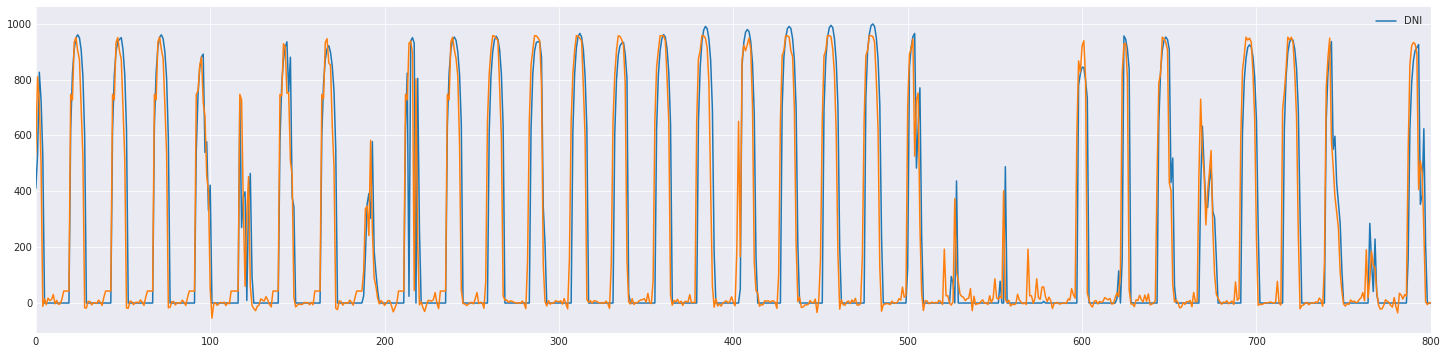

In [14]:
plt.figure(figsize = (25,6))

plot_x1 = np.arange(0,len(y))
plt.plot(plot_x1, y)

plt.plot(plot_x1[:len(y_train)]-1, trainPredict.ravel())
plt.xlim(0,800)
plt.legend()
plt.show()
plt.savefig('../keras_models/LSTM_100x2_batch336_output_2.png')

In [15]:
model.save('../keras_models/LSTM_100x2_batch336_output_2.png')

In [16]:
model = Sequential()

model.add(LSTM(50, batch_input_shape=(batch_size, lag, 1),return_sequences = True, stateful = True))
model.add(LSTM(20, batch_input_shape=(batch_size, lag, 1), stateful = True))
model.add(Dense(1))

model.compile(loss= "mean_squared_error", optimizer = 'adam')

for i in range(3000):
    model.fit(X_train, y_train, epochs = 1, batch_size = batch_size, verbose = 2, shuffle=False)
    model.reset_states()

Epoch 1/1
 - 1s - loss: 215372.7170
Epoch 1/1
 - 0s - loss: 214340.5095
Epoch 1/1
 - 0s - loss: 213188.9961
Epoch 1/1
 - 0s - loss: 212609.3958
Epoch 1/1
 - 0s - loss: 212290.3303
Epoch 1/1
 - 0s - loss: 212031.5082
Epoch 1/1
 - 0s - loss: 211785.8919
Epoch 1/1
 - 0s - loss: 211553.1428
Epoch 1/1
 - 0s - loss: 211326.8880
Epoch 1/1
 - 0s - loss: 211105.3416
Epoch 1/1
 - 0s - loss: 210887.4444
Epoch 1/1
 - 0s - loss: 210672.4653
Epoch 1/1
 - 0s - loss: 210459.9605
Epoch 1/1
 - 0s - loss: 210249.5681
Epoch 1/1
 - 0s - loss: 210041.0217
Epoch 1/1
 - 0s - loss: 209834.0312
Epoch 1/1
 - 0s - loss: 209628.4562
Epoch 1/1
 - 0s - loss: 209424.1710
Epoch 1/1
 - 0s - loss: 209221.0764
Epoch 1/1
 - 0s - loss: 209019.0373
Epoch 1/1
 - 0s - loss: 208818.0143
Epoch 1/1
 - 0s - loss: 208617.9301
Epoch 1/1
 - 0s - loss: 208418.7530
Epoch 1/1
 - 0s - loss: 208220.3607
Epoch 1/1
 - 0s - loss: 208022.7010
Epoch 1/1
 - 0s - loss: 207825.7496
Epoch 1/1
 - 0s - loss: 207629.5521
Epoch 1/1
 - 0s - loss: 2074

Epoch 1/1
 - 0s - loss: 172431.6250
Epoch 1/1
 - 0s - loss: 172285.5187
Epoch 1/1
 - 0s - loss: 172107.1853
Epoch 1/1
 - 0s - loss: 171949.2925
Epoch 1/1
 - 0s - loss: 171821.7739
Epoch 1/1
 - 0s - loss: 171635.2036
Epoch 1/1
 - 0s - loss: 171497.6263
Epoch 1/1
 - 0s - loss: 171290.1250
Epoch 1/1
 - 0s - loss: 171165.7205
Epoch 1/1
 - 0s - loss: 171040.4996
Epoch 1/1
 - 0s - loss: 170943.3728
Epoch 1/1
 - 0s - loss: 170759.0365
Epoch 1/1
 - 0s - loss: 170583.4505
Epoch 1/1
 - 0s - loss: 170371.5556
Epoch 1/1
 - 0s - loss: 170236.4540
Epoch 1/1
 - 0s - loss: 170028.7222
Epoch 1/1
 - 0s - loss: 169907.6471
Epoch 1/1
 - 0s - loss: 169729.4826
Epoch 1/1
 - 0s - loss: 169567.0499
Epoch 1/1
 - 0s - loss: 169374.1819
Epoch 1/1
 - 0s - loss: 169223.5673
Epoch 1/1
 - 0s - loss: 169065.4722
Epoch 1/1
 - 0s - loss: 168895.7487
Epoch 1/1
 - 0s - loss: 168719.7543
Epoch 1/1
 - 0s - loss: 168560.2413
Epoch 1/1
 - 0s - loss: 168392.3485
Epoch 1/1
 - 0s - loss: 168254.1992
Epoch 1/1
 - 0s - loss: 1680

Epoch 1/1
 - 0s - loss: 138716.7305
Epoch 1/1
 - 0s - loss: 138632.9410
Epoch 1/1
 - 0s - loss: 138974.6172
Epoch 1/1
 - 0s - loss: 138742.7361
Epoch 1/1
 - 0s - loss: 138361.3763
Epoch 1/1
 - 0s - loss: 138215.1567
Epoch 1/1
 - 0s - loss: 138144.0404
Epoch 1/1
 - 0s - loss: 137759.1246
Epoch 1/1
 - 0s - loss: 137781.0312
Epoch 1/1
 - 0s - loss: 137475.7305
Epoch 1/1
 - 0s - loss: 137518.1380
Epoch 1/1
 - 0s - loss: 137553.9032
Epoch 1/1
 - 0s - loss: 137198.6406
Epoch 1/1
 - 0s - loss: 137114.6259
Epoch 1/1
 - 0s - loss: 136811.6780
Epoch 1/1
 - 0s - loss: 136903.8906
Epoch 1/1
 - 0s - loss: 136488.1606
Epoch 1/1
 - 0s - loss: 136483.2977
Epoch 1/1
 - 0s - loss: 136338.3073
Epoch 1/1
 - 0s - loss: 136078.4249
Epoch 1/1
 - 0s - loss: 135921.4184
Epoch 1/1
 - 0s - loss: 135792.7292
Epoch 1/1
 - 0s - loss: 135559.6827
Epoch 1/1
 - 0s - loss: 135531.0690
Epoch 1/1
 - 0s - loss: 135460.6029
Epoch 1/1
 - 0s - loss: 135346.1233
Epoch 1/1
 - 0s - loss: 135080.2678
Epoch 1/1
 - 0s - loss: 1349

Epoch 1/1
 - 0s - loss: 107630.3865
Epoch 1/1
 - 0s - loss: 107406.7491
Epoch 1/1
 - 0s - loss: 107352.8422
Epoch 1/1
 - 0s - loss: 107276.4436
Epoch 1/1
 - 0s - loss: 107264.5536
Epoch 1/1
 - 0s - loss: 107557.7400
Epoch 1/1
 - 0s - loss: 107285.2346
Epoch 1/1
 - 0s - loss: 106862.6120
Epoch 1/1
 - 0s - loss: 106769.7107
Epoch 1/1
 - 0s - loss: 106761.3739
Epoch 1/1
 - 0s - loss: 106834.0618
Epoch 1/1
 - 0s - loss: 106576.8965
Epoch 1/1
 - 0s - loss: 106298.9353
Epoch 1/1
 - 0s - loss: 106178.6424
Epoch 1/1
 - 0s - loss: 105882.2279
Epoch 1/1
 - 0s - loss: 105823.3670
Epoch 1/1
 - 0s - loss: 105876.5532
Epoch 1/1
 - 0s - loss: 105702.7795
Epoch 1/1
 - 0s - loss: 105490.2541
Epoch 1/1
 - 0s - loss: 105412.7808
Epoch 1/1
 - 0s - loss: 105230.7066
Epoch 1/1
 - 0s - loss: 105170.7402
Epoch 1/1
 - 0s - loss: 105526.7463
Epoch 1/1
 - 0s - loss: 105533.8262
Epoch 1/1
 - 0s - loss: 105083.1096
Epoch 1/1
 - 0s - loss: 104638.4089
Epoch 1/1
 - 0s - loss: 104554.5558
Epoch 1/1
 - 0s - loss: 1042

 - 0s - loss: 81677.0645
Epoch 1/1
 - 0s - loss: 81589.8477
Epoch 1/1
 - 0s - loss: 81395.2802
Epoch 1/1
 - 0s - loss: 81405.5809
Epoch 1/1
 - 0s - loss: 81156.6994
Epoch 1/1
 - 0s - loss: 81205.0243
Epoch 1/1
 - 0s - loss: 81747.8869
Epoch 1/1
 - 0s - loss: 81113.0352
Epoch 1/1
 - 0s - loss: 81142.6013
Epoch 1/1
 - 0s - loss: 80788.1235
Epoch 1/1
 - 0s - loss: 81011.4093
Epoch 1/1
 - 0s - loss: 80591.0171
Epoch 1/1
 - 0s - loss: 80898.5840
Epoch 1/1
 - 0s - loss: 80992.1604
Epoch 1/1
 - 0s - loss: 80575.4232
Epoch 1/1
 - 0s - loss: 81038.1126
Epoch 1/1
 - 0s - loss: 80301.0579
Epoch 1/1
 - 0s - loss: 79912.0831
Epoch 1/1
 - 0s - loss: 80357.4833
Epoch 1/1
 - 0s - loss: 79692.8997
Epoch 1/1
 - 0s - loss: 79509.5872
Epoch 1/1
 - 0s - loss: 79948.7511
Epoch 1/1
 - 0s - loss: 80313.5918
Epoch 1/1
 - 0s - loss: 79789.7014
Epoch 1/1
 - 0s - loss: 79593.3618
Epoch 1/1
 - 0s - loss: 80023.4271
Epoch 1/1
 - 0s - loss: 79535.3733
Epoch 1/1
 - 0s - loss: 79786.6309
Epoch 1/1
 - 0s - loss: 80366.

Epoch 1/1
 - 0s - loss: 61436.1215
Epoch 1/1
 - 0s - loss: 61165.6905
Epoch 1/1
 - 0s - loss: 60896.7730
Epoch 1/1
 - 0s - loss: 60878.9546
Epoch 1/1
 - 0s - loss: 61300.8839
Epoch 1/1
 - 0s - loss: 60948.8980
Epoch 1/1
 - 0s - loss: 60422.6421
Epoch 1/1
 - 0s - loss: 60170.5833
Epoch 1/1
 - 0s - loss: 60201.5879
Epoch 1/1
 - 0s - loss: 59383.1787
Epoch 1/1
 - 0s - loss: 59314.3605
Epoch 1/1
 - 0s - loss: 59441.5768
Epoch 1/1
 - 0s - loss: 59422.5616
Epoch 1/1
 - 0s - loss: 59877.6903
Epoch 1/1
 - 0s - loss: 59643.4733
Epoch 1/1
 - 0s - loss: 59325.6940
Epoch 1/1
 - 0s - loss: 59047.2140
Epoch 1/1
 - 0s - loss: 58859.1022
Epoch 1/1
 - 0s - loss: 64722.1348
Epoch 1/1
 - 0s - loss: 64142.0556
Epoch 1/1
 - 0s - loss: 62487.7476
Epoch 1/1
 - 0s - loss: 62266.6591
Epoch 1/1
 - 0s - loss: 61361.1185
Epoch 1/1
 - 0s - loss: 60819.0553
Epoch 1/1
 - 0s - loss: 60506.5827
Epoch 1/1
 - 0s - loss: 60530.2274
Epoch 1/1
 - 0s - loss: 59991.9622
Epoch 1/1
 - 0s - loss: 60081.2556
Epoch 1/1
 - 0s - lo

 - 0s - loss: 46752.7810
Epoch 1/1
 - 0s - loss: 46143.1816
Epoch 1/1
 - 0s - loss: 45866.4094
Epoch 1/1
 - 0s - loss: 46022.0515
Epoch 1/1
 - 0s - loss: 46444.4817
Epoch 1/1
 - 0s - loss: 46122.8817
Epoch 1/1
 - 0s - loss: 45689.9568
Epoch 1/1
 - 0s - loss: 45977.4068
Epoch 1/1
 - 0s - loss: 45939.7874
Epoch 1/1
 - 0s - loss: 45986.0408
Epoch 1/1
 - 0s - loss: 45210.8745
Epoch 1/1
 - 0s - loss: 45166.2835
Epoch 1/1
 - 0s - loss: 44601.9275
Epoch 1/1
 - 0s - loss: 44546.0481
Epoch 1/1
 - 0s - loss: 44459.4073
Epoch 1/1
 - 0s - loss: 44316.2700
Epoch 1/1
 - 0s - loss: 44373.0653
Epoch 1/1
 - 0s - loss: 44129.7451
Epoch 1/1
 - 0s - loss: 44019.3147
Epoch 1/1
 - 0s - loss: 44202.0485
Epoch 1/1
 - 0s - loss: 43767.9448
Epoch 1/1
 - 0s - loss: 43948.8207
Epoch 1/1
 - 0s - loss: 43992.9397
Epoch 1/1
 - 0s - loss: 43932.4595
Epoch 1/1
 - 0s - loss: 43436.7744
Epoch 1/1
 - 0s - loss: 43308.5493
Epoch 1/1
 - 0s - loss: 43184.6837
Epoch 1/1
 - 0s - loss: 43525.8917
Epoch 1/1
 - 0s - loss: 43587.

Epoch 1/1
 - 0s - loss: 34502.6135
Epoch 1/1
 - 0s - loss: 33485.9373
Epoch 1/1
 - 0s - loss: 33355.0985
Epoch 1/1
 - 0s - loss: 32235.4860
Epoch 1/1
 - 0s - loss: 31784.8632
Epoch 1/1
 - 0s - loss: 31923.1073
Epoch 1/1
 - 0s - loss: 31297.1135
Epoch 1/1
 - 0s - loss: 31652.8505
Epoch 1/1
 - 0s - loss: 31673.7166
Epoch 1/1
 - 0s - loss: 32035.8497
Epoch 1/1
 - 0s - loss: 32112.5257
Epoch 1/1
 - 0s - loss: 32233.9017
Epoch 1/1
 - 0s - loss: 31896.1458
Epoch 1/1
 - 0s - loss: 31427.6029
Epoch 1/1
 - 0s - loss: 31042.5464
Epoch 1/1
 - 0s - loss: 31183.4607
Epoch 1/1
 - 0s - loss: 30950.1636
Epoch 1/1
 - 0s - loss: 31075.0531
Epoch 1/1
 - 0s - loss: 30621.6004
Epoch 1/1
 - 0s - loss: 30794.4364
Epoch 1/1
 - 0s - loss: 30854.4852
Epoch 1/1
 - 0s - loss: 30596.2171
Epoch 1/1
 - 0s - loss: 30275.6471
Epoch 1/1
 - 0s - loss: 30428.7720
Epoch 1/1
 - 0s - loss: 30640.8213
Epoch 1/1
 - 0s - loss: 30774.0938
Epoch 1/1
 - 0s - loss: 29944.7766
Epoch 1/1
 - 0s - loss: 30196.0775
Epoch 1/1
 - 0s - lo

 - 0s - loss: 21391.6312
Epoch 1/1
 - 0s - loss: 21728.1466
Epoch 1/1
 - 0s - loss: 21894.4504
Epoch 1/1
 - 0s - loss: 21430.8787
Epoch 1/1
 - 0s - loss: 21116.7294
Epoch 1/1
 - 0s - loss: 21001.3339
Epoch 1/1
 - 0s - loss: 20837.1047
Epoch 1/1
 - 0s - loss: 20963.0372
Epoch 1/1
 - 0s - loss: 20877.7426
Epoch 1/1
 - 0s - loss: 21179.7083
Epoch 1/1
 - 0s - loss: 21438.2273
Epoch 1/1
 - 0s - loss: 20770.7381
Epoch 1/1
 - 0s - loss: 21186.1804
Epoch 1/1
 - 0s - loss: 20529.1154
Epoch 1/1
 - 0s - loss: 20902.8850
Epoch 1/1
 - 0s - loss: 21376.7943
Epoch 1/1
 - 0s - loss: 21843.5227
Epoch 1/1
 - 0s - loss: 21543.6459
Epoch 1/1
 - 0s - loss: 21237.4199
Epoch 1/1
 - 0s - loss: 21080.5021
Epoch 1/1
 - 0s - loss: 21260.0175
Epoch 1/1
 - 0s - loss: 21038.7607
Epoch 1/1
 - 0s - loss: 20923.6409
Epoch 1/1
 - 0s - loss: 20788.8465
Epoch 1/1
 - 0s - loss: 20763.4077
Epoch 1/1
 - 0s - loss: 20515.9239
Epoch 1/1
 - 0s - loss: 20529.2497
Epoch 1/1
 - 0s - loss: 20414.9393
Epoch 1/1
 - 0s - loss: 20438.

Epoch 1/1
 - 0s - loss: 14732.7378
Epoch 1/1
 - 0s - loss: 15894.0392
Epoch 1/1
 - 0s - loss: 15569.9323
Epoch 1/1
 - 0s - loss: 15558.8927
Epoch 1/1
 - 0s - loss: 15563.4954
Epoch 1/1
 - 0s - loss: 15510.5146
Epoch 1/1
 - 0s - loss: 15872.0964
Epoch 1/1
 - 0s - loss: 15245.7666
Epoch 1/1
 - 0s - loss: 15226.4371
Epoch 1/1
 - 0s - loss: 15473.8202
Epoch 1/1
 - 0s - loss: 15177.1527
Epoch 1/1
 - 0s - loss: 15068.1166
Epoch 1/1
 - 0s - loss: 14968.1676
Epoch 1/1
 - 0s - loss: 14533.7258
Epoch 1/1
 - 0s - loss: 14461.3209
Epoch 1/1
 - 0s - loss: 14052.6635
Epoch 1/1
 - 0s - loss: 14103.3346
Epoch 1/1
 - 0s - loss: 14253.8837
Epoch 1/1
 - 0s - loss: 14311.5751
Epoch 1/1
 - 0s - loss: 14371.3126
Epoch 1/1
 - 0s - loss: 14560.6111
Epoch 1/1
 - 0s - loss: 14463.4465
Epoch 1/1
 - 0s - loss: 14317.1353
Epoch 1/1
 - 0s - loss: 14527.5713
Epoch 1/1
 - 0s - loss: 14392.0609
Epoch 1/1
 - 0s - loss: 14961.9763
Epoch 1/1
 - 0s - loss: 15738.4366
Epoch 1/1
 - 0s - loss: 16582.0640
Epoch 1/1
 - 0s - lo

 - 0s - loss: 10674.4409
Epoch 1/1
 - 0s - loss: 9893.9215
Epoch 1/1
 - 0s - loss: 9767.0920
Epoch 1/1
 - 0s - loss: 9931.9343
Epoch 1/1
 - 0s - loss: 9897.8261
Epoch 1/1
 - 0s - loss: 10118.9294
Epoch 1/1
 - 0s - loss: 10416.3081
Epoch 1/1
 - 0s - loss: 10544.0645
Epoch 1/1
 - 0s - loss: 10967.0710
Epoch 1/1
 - 0s - loss: 12231.5673
Epoch 1/1
 - 0s - loss: 12238.3545
Epoch 1/1
 - 0s - loss: 12947.4016
Epoch 1/1
 - 0s - loss: 13323.0828
Epoch 1/1
 - 0s - loss: 13990.5865
Epoch 1/1
 - 0s - loss: 12541.6857
Epoch 1/1
 - 0s - loss: 11705.9322
Epoch 1/1
 - 0s - loss: 10637.8156
Epoch 1/1
 - 0s - loss: 11430.8092
Epoch 1/1
 - 0s - loss: 10723.9233
Epoch 1/1
 - 0s - loss: 11604.1007
Epoch 1/1
 - 0s - loss: 12687.2919
Epoch 1/1
 - 0s - loss: 12790.6704
Epoch 1/1
 - 0s - loss: 11297.8431
Epoch 1/1
 - 0s - loss: 10482.8761
Epoch 1/1
 - 0s - loss: 10453.1244
Epoch 1/1
 - 0s - loss: 10315.7892
Epoch 1/1
 - 0s - loss: 10192.7664
Epoch 1/1
 - 0s - loss: 9950.7853
Epoch 1/1
 - 0s - loss: 9850.5809
E

Epoch 1/1
 - 0s - loss: 9665.3341
Epoch 1/1
 - 0s - loss: 8432.4915
Epoch 1/1
 - 0s - loss: 8703.3263
Epoch 1/1
 - 0s - loss: 8056.9093
Epoch 1/1
 - 0s - loss: 7978.2336
Epoch 1/1
 - 0s - loss: 7937.0515
Epoch 1/1
 - 0s - loss: 7751.7065
Epoch 1/1
 - 0s - loss: 7799.1371
Epoch 1/1
 - 0s - loss: 7694.7021
Epoch 1/1
 - 0s - loss: 7808.9515
Epoch 1/1
 - 0s - loss: 7762.2402
Epoch 1/1
 - 0s - loss: 7734.8174
Epoch 1/1
 - 0s - loss: 8483.9478
Epoch 1/1
 - 0s - loss: 8306.9096
Epoch 1/1
 - 0s - loss: 8219.9511
Epoch 1/1
 - 0s - loss: 7951.7929
Epoch 1/1
 - 0s - loss: 7605.9219
Epoch 1/1
 - 0s - loss: 7557.0622
Epoch 1/1
 - 0s - loss: 8595.2879
Epoch 1/1
 - 0s - loss: 8889.1987
Epoch 1/1
 - 0s - loss: 8600.1974
Epoch 1/1
 - 0s - loss: 8691.4017
Epoch 1/1
 - 0s - loss: 8415.3469
Epoch 1/1
 - 0s - loss: 8807.3600
Epoch 1/1
 - 0s - loss: 7727.3819
Epoch 1/1
 - 0s - loss: 7543.6256
Epoch 1/1
 - 0s - loss: 8402.1914
Epoch 1/1
 - 0s - loss: 7819.7248
Epoch 1/1
 - 0s - loss: 7800.0572
Epoch 1/1
 - 0

Epoch 1/1
 - 0s - loss: 9595.0531
Epoch 1/1
 - 0s - loss: 9106.1263
Epoch 1/1
 - 0s - loss: 8388.4486
Epoch 1/1
 - 0s - loss: 8463.1967
Epoch 1/1
 - 0s - loss: 8360.4294
Epoch 1/1
 - 0s - loss: 9621.5529
Epoch 1/1
 - 0s - loss: 9885.7127
Epoch 1/1
 - 0s - loss: 8547.1469
Epoch 1/1
 - 0s - loss: 8316.8537
Epoch 1/1
 - 0s - loss: 8001.8326
Epoch 1/1
 - 0s - loss: 7986.5665
Epoch 1/1
 - 0s - loss: 8959.2134
Epoch 1/1
 - 0s - loss: 8200.4524
Epoch 1/1
 - 0s - loss: 7847.1371
Epoch 1/1
 - 0s - loss: 8817.0571
Epoch 1/1
 - 0s - loss: 8231.9317
Epoch 1/1
 - 0s - loss: 8159.8819
Epoch 1/1
 - 0s - loss: 8636.4817
Epoch 1/1
 - 0s - loss: 8433.4545
Epoch 1/1
 - 0s - loss: 8928.6920
Epoch 1/1
 - 0s - loss: 10039.2039
Epoch 1/1
 - 0s - loss: 9112.0139
Epoch 1/1
 - 0s - loss: 8924.3436
Epoch 1/1
 - 0s - loss: 8666.1866
Epoch 1/1
 - 0s - loss: 9410.9468
Epoch 1/1
 - 0s - loss: 9099.3577
Epoch 1/1
 - 0s - loss: 9098.9788
Epoch 1/1
 - 0s - loss: 8754.4463
Epoch 1/1
 - 0s - loss: 8417.8246
Epoch 1/1
 - 

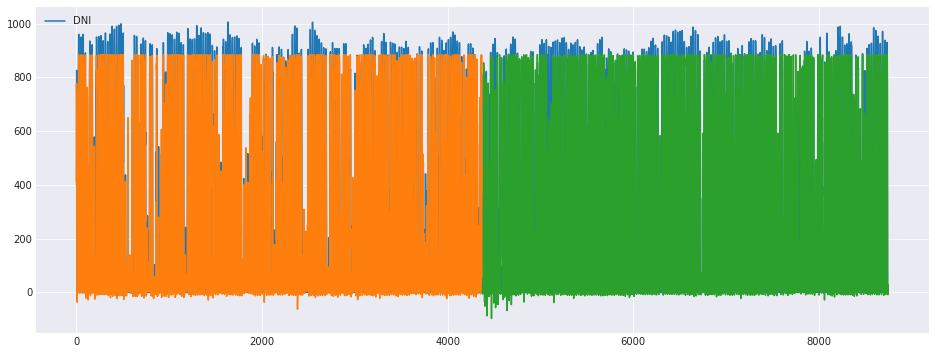

In [17]:
trainPredict = model.predict(X_train,batch_size=batch_size)
model.reset_states()
testPredict = model.predict(X_test,batch_size=batch_size)
model.reset_states()

plt.figure(figsize = (16,6))

plot_x1 = np.arange(0,len(y))
plt.plot(plot_x1, y)

# plt.plot(plot_x1-1, np.append(trainPredict,testPredict))

plt.plot(plot_x1[:len(y_train)]-1, trainPredict.ravel())

plt.plot(plot_x1[len(y_test):], testPredict.ravel())

plt.legend()
plt.show()
plt.savefig('../keras_models/LSTM_50_20_lag12_batch336_output.png')

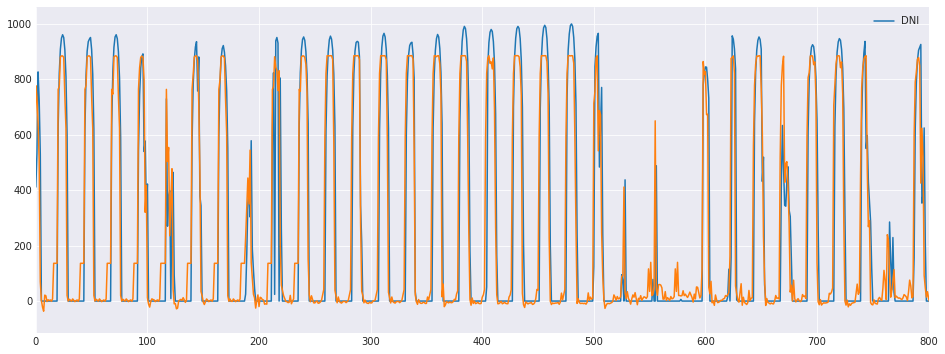

In [18]:
plt.figure(figsize = (16,6))

plot_x1 = np.arange(0,len(y))
plt.plot(plot_x1, y)

plt.plot(plot_x1[:len(y_train)]-1, trainPredict.ravel())
plt.xlim(0,800)
plt.legend()
plt.show()
plt.savefig('../keras_models/LSTM_50_20_lag12_batch336_output_2.png')

In [19]:
model.save('LSTM_50_20_lag12_batch336')

In [20]:
model = Sequential()

model.add(LSTM(100, input_shape = (lag,1)))
model.add(Dense(1))

model.compile(loss= "mean_squared_error", optimizer = 'adam')

model.fit(X_train, y_train, epochs = 3000, batch_size = batch_size, verbose = 2, shuffle=False)
model.save('../keras_models/LSTM_100flat_lag12_batch336')

Epoch 1/3000
 - 1s - loss: 214516.0334
Epoch 2/3000
 - 0s - loss: 210639.8138
Epoch 3/3000
 - 0s - loss: 207309.4436
Epoch 4/3000
 - 0s - loss: 205839.0764
Epoch 5/3000
 - 0s - loss: 204639.8203
Epoch 6/3000
 - 0s - loss: 203510.7352
Epoch 7/3000
 - 0s - loss: 202440.9492
Epoch 8/3000
 - 0s - loss: 201400.8702
Epoch 9/3000
 - 0s - loss: 200407.8459
Epoch 10/3000
 - 0s - loss: 199436.0356
Epoch 11/3000
 - 0s - loss: 198486.7370
Epoch 12/3000
 - 0s - loss: 197567.3533
Epoch 13/3000
 - 0s - loss: 196657.9319
Epoch 14/3000
 - 0s - loss: 195770.9219
Epoch 15/3000
 - 0s - loss: 194907.3516
Epoch 16/3000
 - 0s - loss: 194052.4787
Epoch 17/3000
 - 0s - loss: 193203.2730
Epoch 18/3000
 - 0s - loss: 192361.0777
Epoch 19/3000
 - 0s - loss: 191547.1280
Epoch 20/3000
 - 0s - loss: 190713.3976
Epoch 21/3000
 - 0s - loss: 189913.4744
Epoch 22/3000
 - 0s - loss: 189107.9145
Epoch 23/3000
 - 0s - loss: 188306.4457
Epoch 24/3000
 - 0s - loss: 187514.3676
Epoch 25/3000
 - 0s - loss: 186713.6176
Epoch 26/

 - 0s - loss: 85653.9080
Epoch 205/3000
 - 0s - loss: 85239.2674
Epoch 206/3000
 - 0s - loss: 85431.4963
Epoch 207/3000
 - 0s - loss: 87112.1651
Epoch 208/3000
 - 0s - loss: 85667.5215
Epoch 209/3000
 - 0s - loss: 84609.0150
Epoch 210/3000
 - 0s - loss: 83779.0143
Epoch 211/3000
 - 0s - loss: 83627.1929
Epoch 212/3000
 - 0s - loss: 83127.8665
Epoch 213/3000
 - 0s - loss: 83024.2422
Epoch 214/3000
 - 0s - loss: 83243.7383
Epoch 215/3000
 - 0s - loss: 82190.6196
Epoch 216/3000
 - 0s - loss: 81966.9442
Epoch 217/3000
 - 0s - loss: 81356.2901
Epoch 218/3000
 - 0s - loss: 81432.9010
Epoch 219/3000
 - 0s - loss: 80735.4596
Epoch 220/3000
 - 0s - loss: 80335.7563
Epoch 221/3000
 - 0s - loss: 80219.9746
Epoch 222/3000
 - 0s - loss: 80243.7363
Epoch 223/3000
 - 0s - loss: 79606.9143
Epoch 224/3000
 - 0s - loss: 78738.3047
Epoch 225/3000
 - 0s - loss: 78590.2452
Epoch 226/3000
 - 0s - loss: 78702.9484
Epoch 227/3000
 - 0s - loss: 78791.0343
Epoch 228/3000
 - 0s - loss: 77654.5215
Epoch 229/3000


 - 0s - loss: 38628.5165
Epoch 410/3000
 - 0s - loss: 38473.5016
Epoch 411/3000
 - 0s - loss: 39869.8471
Epoch 412/3000
 - 0s - loss: 38296.1960
Epoch 413/3000
 - 0s - loss: 38370.2870
Epoch 414/3000
 - 0s - loss: 37830.9059
Epoch 415/3000
 - 0s - loss: 38021.0788
Epoch 416/3000
 - 0s - loss: 37758.6288
Epoch 417/3000
 - 0s - loss: 38165.2623
Epoch 418/3000
 - 0s - loss: 37296.3141
Epoch 419/3000
 - 0s - loss: 36866.6681
Epoch 420/3000
 - 0s - loss: 36595.1789
Epoch 421/3000
 - 0s - loss: 37030.2881
Epoch 422/3000
 - 0s - loss: 37403.1969
Epoch 423/3000
 - 0s - loss: 38925.7879
Epoch 424/3000
 - 0s - loss: 38333.1928
Epoch 425/3000
 - 0s - loss: 37142.5081
Epoch 426/3000
 - 0s - loss: 37809.6984
Epoch 427/3000
 - 0s - loss: 38943.6176
Epoch 428/3000
 - 0s - loss: 40346.6606
Epoch 429/3000
 - 0s - loss: 37245.8602
Epoch 430/3000
 - 0s - loss: 37912.8332
Epoch 431/3000
 - 0s - loss: 36113.2152
Epoch 432/3000
 - 0s - loss: 35578.4838
Epoch 433/3000
 - 0s - loss: 38618.3571
Epoch 434/3000


 - 0s - loss: 19118.2918
Epoch 615/3000
 - 0s - loss: 18696.0932
Epoch 616/3000
 - 0s - loss: 18971.3379
Epoch 617/3000
 - 0s - loss: 18921.5520
Epoch 618/3000
 - 0s - loss: 18765.4481
Epoch 619/3000
 - 0s - loss: 19508.3356
Epoch 620/3000
 - 0s - loss: 18482.3120
Epoch 621/3000
 - 0s - loss: 17490.1596
Epoch 622/3000
 - 0s - loss: 17621.5232
Epoch 623/3000
 - 0s - loss: 17168.0045
Epoch 624/3000
 - 0s - loss: 17187.8979
Epoch 625/3000
 - 0s - loss: 16968.6270
Epoch 626/3000
 - 0s - loss: 18012.6484
Epoch 627/3000
 - 0s - loss: 17593.2368
Epoch 628/3000
 - 0s - loss: 17331.4347
Epoch 629/3000
 - 0s - loss: 17494.0458
Epoch 630/3000
 - 0s - loss: 17261.0355
Epoch 631/3000
 - 0s - loss: 17216.4576
Epoch 632/3000
 - 0s - loss: 17150.8091
Epoch 633/3000
 - 0s - loss: 17343.6509
Epoch 634/3000
 - 0s - loss: 16820.6157
Epoch 635/3000
 - 0s - loss: 17115.6440
Epoch 636/3000
 - 0s - loss: 16709.3281
Epoch 637/3000
 - 0s - loss: 16841.1596
Epoch 638/3000
 - 0s - loss: 16778.3783
Epoch 639/3000


 - 0s - loss: 13599.3862
Epoch 820/3000
 - 0s - loss: 14073.4487
Epoch 821/3000
 - 0s - loss: 13463.6330
Epoch 822/3000
 - 0s - loss: 14612.6454
Epoch 823/3000
 - 0s - loss: 15156.3983
Epoch 824/3000
 - 0s - loss: 14345.5492
Epoch 825/3000
 - 0s - loss: 14127.1462
Epoch 826/3000
 - 0s - loss: 13736.3754
Epoch 827/3000
 - 0s - loss: 13482.8677
Epoch 828/3000
 - 0s - loss: 13614.8053
Epoch 829/3000
 - 0s - loss: 13231.6019
Epoch 830/3000
 - 0s - loss: 13109.1650
Epoch 831/3000
 - 0s - loss: 13114.2999
Epoch 832/3000
 - 0s - loss: 13324.9784
Epoch 833/3000
 - 0s - loss: 13040.0438
Epoch 834/3000
 - 0s - loss: 13186.0063
Epoch 835/3000
 - 0s - loss: 12950.8975
Epoch 836/3000
 - 0s - loss: 12685.2253
Epoch 837/3000
 - 0s - loss: 13282.5987
Epoch 838/3000
 - 0s - loss: 13204.2145
Epoch 839/3000
 - 0s - loss: 12997.4577
Epoch 840/3000
 - 0s - loss: 13152.0459
Epoch 841/3000
 - 0s - loss: 13015.6227
Epoch 842/3000
 - 0s - loss: 13017.2140
Epoch 843/3000
 - 0s - loss: 13409.2919
Epoch 844/3000


Epoch 1024/3000
 - 0s - loss: 12466.8603
Epoch 1025/3000
 - 0s - loss: 12779.9290
Epoch 1026/3000
 - 0s - loss: 11878.2939
Epoch 1027/3000
 - 0s - loss: 12010.7700
Epoch 1028/3000
 - 0s - loss: 12149.4052
Epoch 1029/3000
 - 0s - loss: 12299.4208
Epoch 1030/3000
 - 0s - loss: 12411.2458
Epoch 1031/3000
 - 0s - loss: 11906.5294
Epoch 1032/3000
 - 0s - loss: 12113.6611
Epoch 1033/3000
 - 0s - loss: 12354.2167
Epoch 1034/3000
 - 0s - loss: 12941.7312
Epoch 1035/3000
 - 0s - loss: 12879.6420
Epoch 1036/3000
 - 0s - loss: 17660.9126
Epoch 1037/3000
 - 0s - loss: 15036.5078
Epoch 1038/3000
 - 0s - loss: 13014.9746
Epoch 1039/3000
 - 0s - loss: 12672.6455
Epoch 1040/3000
 - 0s - loss: 12130.8292
Epoch 1041/3000
 - 0s - loss: 11935.3724
Epoch 1042/3000
 - 0s - loss: 11962.2562
Epoch 1043/3000
 - 0s - loss: 11965.1710
Epoch 1044/3000
 - 0s - loss: 11702.2046
Epoch 1045/3000
 - 0s - loss: 12089.4413
Epoch 1046/3000
 - 0s - loss: 12326.9693
Epoch 1047/3000
 - 0s - loss: 11912.8118
Epoch 1048/3000


Epoch 1224/3000
 - 0s - loss: 11560.7052
Epoch 1225/3000
 - 0s - loss: 11266.5325
Epoch 1226/3000
 - 0s - loss: 12847.3315
Epoch 1227/3000
 - 0s - loss: 13802.8219
Epoch 1228/3000
 - 0s - loss: 14566.2908
Epoch 1229/3000
 - 0s - loss: 14060.2695
Epoch 1230/3000
 - 0s - loss: 12990.6552
Epoch 1231/3000
 - 0s - loss: 13153.8523
Epoch 1232/3000
 - 0s - loss: 13656.0754
Epoch 1233/3000
 - 0s - loss: 13161.1794
Epoch 1234/3000
 - 0s - loss: 12302.9788
Epoch 1235/3000
 - 0s - loss: 12260.7266
Epoch 1236/3000
 - 0s - loss: 11413.5217
Epoch 1237/3000
 - 0s - loss: 13553.5687
Epoch 1238/3000
 - 0s - loss: 14979.5521
Epoch 1239/3000
 - 0s - loss: 13222.8262
Epoch 1240/3000
 - 0s - loss: 12303.8034
Epoch 1241/3000
 - 0s - loss: 12492.4970
Epoch 1242/3000
 - 0s - loss: 11642.3786
Epoch 1243/3000
 - 0s - loss: 11296.1953
Epoch 1244/3000
 - 0s - loss: 11173.1219
Epoch 1245/3000
 - 0s - loss: 11612.4945
Epoch 1246/3000
 - 0s - loss: 11361.6051
Epoch 1247/3000
 - 0s - loss: 12389.7858
Epoch 1248/3000


Epoch 1424/3000
 - 0s - loss: 11459.2370
Epoch 1425/3000
 - 0s - loss: 12119.6125
Epoch 1426/3000
 - 0s - loss: 14170.9729
Epoch 1427/3000
 - 0s - loss: 13512.8675
Epoch 1428/3000
 - 0s - loss: 11959.3601
Epoch 1429/3000
 - 0s - loss: 10932.7976
Epoch 1430/3000
 - 0s - loss: 10622.3402
Epoch 1431/3000
 - 0s - loss: 10660.5229
Epoch 1432/3000
 - 0s - loss: 10674.5508
Epoch 1433/3000
 - 0s - loss: 10821.3039
Epoch 1434/3000
 - 0s - loss: 11957.2374
Epoch 1435/3000
 - 0s - loss: 12073.5641
Epoch 1436/3000
 - 0s - loss: 11461.7557
Epoch 1437/3000
 - 0s - loss: 10982.8307
Epoch 1438/3000
 - 0s - loss: 10680.1801
Epoch 1439/3000
 - 0s - loss: 11318.9605
Epoch 1440/3000
 - 0s - loss: 11122.2489
Epoch 1441/3000
 - 0s - loss: 12646.3917
Epoch 1442/3000
 - 0s - loss: 11637.5960
Epoch 1443/3000
 - 0s - loss: 11314.1344
Epoch 1444/3000
 - 0s - loss: 11192.6805
Epoch 1445/3000
 - 0s - loss: 11106.4265
Epoch 1446/3000
 - 0s - loss: 10503.6185
Epoch 1447/3000
 - 0s - loss: 10353.0120
Epoch 1448/3000


Epoch 1624/3000
 - 0s - loss: 10135.2578
Epoch 1625/3000
 - 0s - loss: 10186.0824
Epoch 1626/3000
 - 0s - loss: 10042.0305
Epoch 1627/3000
 - 0s - loss: 10078.6342
Epoch 1628/3000
 - 0s - loss: 10083.2203
Epoch 1629/3000
 - 0s - loss: 11578.6130
Epoch 1630/3000
 - 0s - loss: 10664.8302
Epoch 1631/3000
 - 0s - loss: 11539.9385
Epoch 1632/3000
 - 0s - loss: 13013.3610
Epoch 1633/3000
 - 0s - loss: 11658.2748
Epoch 1634/3000
 - 0s - loss: 11527.1652
Epoch 1635/3000
 - 0s - loss: 11337.3015
Epoch 1636/3000
 - 0s - loss: 10711.9758
Epoch 1637/3000
 - 0s - loss: 10424.1127
Epoch 1638/3000
 - 0s - loss: 9933.8269
Epoch 1639/3000
 - 0s - loss: 9761.4213
Epoch 1640/3000
 - 0s - loss: 10301.9151
Epoch 1641/3000
 - 0s - loss: 10678.0462
Epoch 1642/3000
 - 0s - loss: 10563.8688
Epoch 1643/3000
 - 0s - loss: 10260.6336
Epoch 1644/3000
 - 0s - loss: 9820.5332
Epoch 1645/3000
 - 0s - loss: 9641.7425
Epoch 1646/3000
 - 0s - loss: 9980.7429
Epoch 1647/3000
 - 0s - loss: 10278.3026
Epoch 1648/3000
 - 0s

Epoch 1826/3000
 - 0s - loss: 10038.6014
Epoch 1827/3000
 - 0s - loss: 9635.1996
Epoch 1828/3000
 - 0s - loss: 9589.7369
Epoch 1829/3000
 - 0s - loss: 9402.6354
Epoch 1830/3000
 - 0s - loss: 10068.7974
Epoch 1831/3000
 - 0s - loss: 10050.2646
Epoch 1832/3000
 - 0s - loss: 11279.0787
Epoch 1833/3000
 - 0s - loss: 11533.8118
Epoch 1834/3000
 - 0s - loss: 12160.0514
Epoch 1835/3000
 - 0s - loss: 11423.4169
Epoch 1836/3000
 - 0s - loss: 10590.2069
Epoch 1837/3000
 - 0s - loss: 10267.5468
Epoch 1838/3000
 - 0s - loss: 9867.6312
Epoch 1839/3000
 - 0s - loss: 10237.6588
Epoch 1840/3000
 - 0s - loss: 9907.2228
Epoch 1841/3000
 - 0s - loss: 10009.3058
Epoch 1842/3000
 - 0s - loss: 10148.9775
Epoch 1843/3000
 - 0s - loss: 10173.2673
Epoch 1844/3000
 - 0s - loss: 10337.4392
Epoch 1845/3000
 - 0s - loss: 10008.6679
Epoch 1846/3000
 - 0s - loss: 9877.4968
Epoch 1847/3000
 - 0s - loss: 9982.9632
Epoch 1848/3000
 - 0s - loss: 9730.4781
Epoch 1849/3000
 - 0s - loss: 9669.0732
Epoch 1850/3000
 - 0s - l

 - 0s - loss: 10809.8085
Epoch 2029/3000
 - 0s - loss: 9853.7039
Epoch 2030/3000
 - 0s - loss: 9969.7996
Epoch 2031/3000
 - 0s - loss: 9955.9042
Epoch 2032/3000
 - 0s - loss: 9915.9780
Epoch 2033/3000
 - 0s - loss: 9464.2046
Epoch 2034/3000
 - 0s - loss: 9337.9031
Epoch 2035/3000
 - 0s - loss: 9199.9462
Epoch 2036/3000
 - 0s - loss: 9288.2447
Epoch 2037/3000
 - 0s - loss: 11416.9401
Epoch 2038/3000
 - 0s - loss: 12744.5079
Epoch 2039/3000
 - 0s - loss: 12321.1220
Epoch 2040/3000
 - 0s - loss: 11505.0050
Epoch 2041/3000
 - 0s - loss: 10850.6373
Epoch 2042/3000
 - 0s - loss: 10710.4259
Epoch 2043/3000
 - 0s - loss: 10825.2238
Epoch 2044/3000
 - 0s - loss: 11110.3634
Epoch 2045/3000
 - 0s - loss: 10296.7068
Epoch 2046/3000
 - 0s - loss: 10066.1917
Epoch 2047/3000
 - 0s - loss: 10197.3681
Epoch 2048/3000
 - 0s - loss: 9892.7386
Epoch 2049/3000
 - 0s - loss: 9800.4882
Epoch 2050/3000
 - 0s - loss: 9782.8456
Epoch 2051/3000
 - 0s - loss: 9878.5061
Epoch 2052/3000
 - 0s - loss: 9660.3671
Epoc

 - 0s - loss: 9342.3941
Epoch 2232/3000
 - 0s - loss: 9266.4704
Epoch 2233/3000
 - 0s - loss: 9249.0732
Epoch 2234/3000
 - 0s - loss: 9015.2012
Epoch 2235/3000
 - 0s - loss: 9155.9389
Epoch 2236/3000
 - 0s - loss: 9013.6863
Epoch 2237/3000
 - 0s - loss: 9466.7221
Epoch 2238/3000
 - 0s - loss: 9654.6140
Epoch 2239/3000
 - 0s - loss: 9925.9714
Epoch 2240/3000
 - 0s - loss: 9758.9257
Epoch 2241/3000
 - 0s - loss: 9928.0366
Epoch 2242/3000
 - 0s - loss: 9273.0783
Epoch 2243/3000
 - 0s - loss: 9565.7464
Epoch 2244/3000
 - 0s - loss: 12304.7495
Epoch 2245/3000
 - 0s - loss: 12805.9855
Epoch 2246/3000
 - 0s - loss: 12860.4116
Epoch 2247/3000
 - 0s - loss: 12101.9870
Epoch 2248/3000
 - 0s - loss: 10945.1171
Epoch 2249/3000
 - 0s - loss: 10380.8455
Epoch 2250/3000
 - 0s - loss: 10572.6271
Epoch 2251/3000
 - 0s - loss: 10423.0169
Epoch 2252/3000
 - 0s - loss: 11227.9098
Epoch 2253/3000
 - 0s - loss: 10990.0020
Epoch 2254/3000
 - 0s - loss: 9896.4848
Epoch 2255/3000
 - 0s - loss: 9651.1385
Epoch 

Epoch 2435/3000
 - 0s - loss: 10228.4616
Epoch 2436/3000
 - 0s - loss: 9744.7616
Epoch 2437/3000
 - 0s - loss: 10078.1643
Epoch 2438/3000
 - 0s - loss: 9783.3656
Epoch 2439/3000
 - 0s - loss: 9781.6832
Epoch 2440/3000
 - 0s - loss: 9842.5007
Epoch 2441/3000
 - 0s - loss: 9991.9928
Epoch 2442/3000
 - 0s - loss: 9800.7198
Epoch 2443/3000
 - 0s - loss: 9389.1700
Epoch 2444/3000
 - 0s - loss: 9513.7696
Epoch 2445/3000
 - 0s - loss: 9348.8027
Epoch 2446/3000
 - 0s - loss: 9286.0561
Epoch 2447/3000
 - 0s - loss: 9280.7803
Epoch 2448/3000
 - 0s - loss: 8949.6276
Epoch 2449/3000
 - 0s - loss: 9088.2821
Epoch 2450/3000
 - 0s - loss: 9053.9392
Epoch 2451/3000
 - 0s - loss: 9052.6819
Epoch 2452/3000
 - 0s - loss: 9364.6275
Epoch 2453/3000
 - 0s - loss: 9132.4365
Epoch 2454/3000
 - 0s - loss: 8979.1518
Epoch 2455/3000
 - 0s - loss: 9035.1681
Epoch 2456/3000
 - 0s - loss: 8972.7713
Epoch 2457/3000
 - 0s - loss: 9174.9872
Epoch 2458/3000
 - 0s - loss: 8895.9066
Epoch 2459/3000
 - 0s - loss: 8973.805

Epoch 2639/3000
 - 0s - loss: 13027.4475
Epoch 2640/3000
 - 0s - loss: 11947.0280
Epoch 2641/3000
 - 0s - loss: 11752.5621
Epoch 2642/3000
 - 0s - loss: 10924.1791
Epoch 2643/3000
 - 0s - loss: 10739.4778
Epoch 2644/3000
 - 0s - loss: 10298.4075
Epoch 2645/3000
 - 0s - loss: 9859.9434
Epoch 2646/3000
 - 0s - loss: 10384.2994
Epoch 2647/3000
 - 0s - loss: 10078.2417
Epoch 2648/3000
 - 0s - loss: 9998.1831
Epoch 2649/3000
 - 0s - loss: 11501.8497
Epoch 2650/3000
 - 0s - loss: 11118.4342
Epoch 2651/3000
 - 0s - loss: 10731.8447
Epoch 2652/3000
 - 0s - loss: 10145.3257
Epoch 2653/3000
 - 0s - loss: 9768.0334
Epoch 2654/3000
 - 0s - loss: 9932.8217
Epoch 2655/3000
 - 0s - loss: 9393.8983
Epoch 2656/3000
 - 0s - loss: 9399.5081
Epoch 2657/3000
 - 0s - loss: 9361.1988
Epoch 2658/3000
 - 0s - loss: 9518.8004
Epoch 2659/3000
 - 0s - loss: 9462.3158
Epoch 2660/3000
 - 0s - loss: 9680.1166
Epoch 2661/3000
 - 0s - loss: 9519.6735
Epoch 2662/3000
 - 0s - loss: 9390.5691
Epoch 2663/3000
 - 0s - loss

Epoch 2843/3000
 - 0s - loss: 9013.3700
Epoch 2844/3000
 - 0s - loss: 9000.8763
Epoch 2845/3000
 - 0s - loss: 8917.4608
Epoch 2846/3000
 - 0s - loss: 8676.2848
Epoch 2847/3000
 - 0s - loss: 8564.2780
Epoch 2848/3000
 - 0s - loss: 8540.7831
Epoch 2849/3000
 - 0s - loss: 8579.9937
Epoch 2850/3000
 - 0s - loss: 8425.1337
Epoch 2851/3000
 - 0s - loss: 8569.2587
Epoch 2852/3000
 - 0s - loss: 8753.8778
Epoch 2853/3000
 - 0s - loss: 8595.8880
Epoch 2854/3000
 - 0s - loss: 8705.4059
Epoch 2855/3000
 - 0s - loss: 9957.4821
Epoch 2856/3000
 - 0s - loss: 10477.9931
Epoch 2857/3000
 - 0s - loss: 9655.1273
Epoch 2858/3000
 - 0s - loss: 10430.7401
Epoch 2859/3000
 - 0s - loss: 10762.1562
Epoch 2860/3000
 - 0s - loss: 10266.6913
Epoch 2861/3000
 - 0s - loss: 10311.6670
Epoch 2862/3000
 - 0s - loss: 9674.6992
Epoch 2863/3000
 - 0s - loss: 9575.6156
Epoch 2864/3000
 - 0s - loss: 9478.7553
Epoch 2865/3000
 - 0s - loss: 9371.2559
Epoch 2866/3000
 - 0s - loss: 8902.6427
Epoch 2867/3000
 - 0s - loss: 8788.

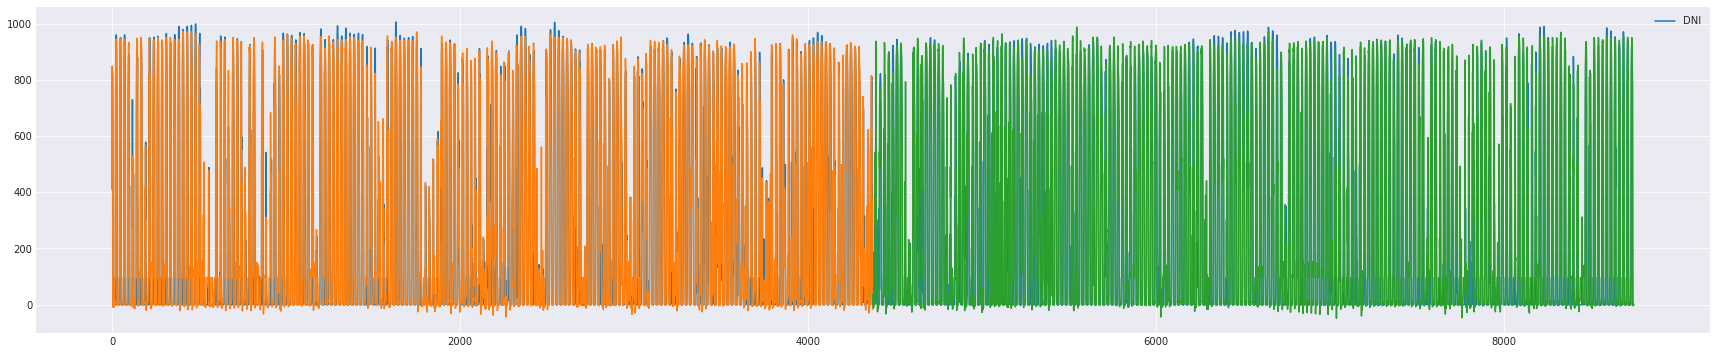

In [21]:
trainPredict = model.predict(X_train,batch_size=batch_size)
model.reset_states()
testPredict = model.predict(X_test,batch_size=batch_size)
model.reset_states()

plt.figure(figsize = (30,6))

plot_x1 = np.arange(0,len(y))
plt.plot(plot_x1, y)

# plt.plot(plot_x1-1, np.append(trainPredict,testPredict))

plt.plot(plot_x1[:len(y_train)]-1, trainPredict.ravel())

plt.plot(plot_x1[len(y_test):], testPredict.ravel())

plt.legend()
plt.show()
plt.savefig('../keras_models/LSTM_100flat_lag12_batch336_output.png')

In [22]:
model = Sequential()

model.add(LSTM(100, batch_input_shape=(batch_size, lag, 1),return_sequences = True))
model.add(LSTM(100, batch_input_shape=(batch_size, lag, 1)))
model.add(Dense(1))

model.compile(loss= "mean_squared_error", optimizer = 'adam')

model.fit(X_train, y_train, epochs = 3000, batch_size = batch_size, verbose = 2, shuffle=False)
model.save('../keras_models/LSTM_100x2flat_lag12_batch336')

Epoch 1/3000
 - 1s - loss: 213695.5091
Epoch 2/3000
 - 0s - loss: 209364.8238
Epoch 3/3000
 - 0s - loss: 207843.9223
Epoch 4/3000
 - 0s - loss: 206734.6949
Epoch 5/3000
 - 0s - loss: 205691.8181
Epoch 6/3000
 - 0s - loss: 204693.8003
Epoch 7/3000
 - 0s - loss: 203728.0582
Epoch 8/3000
 - 0s - loss: 202787.5078
Epoch 9/3000
 - 0s - loss: 201867.5204
Epoch 10/3000
 - 0s - loss: 200965.3668
Epoch 11/3000
 - 0s - loss: 200078.6758
Epoch 12/3000
 - 0s - loss: 199206.1411
Epoch 13/3000
 - 0s - loss: 198346.7574
Epoch 14/3000
 - 0s - loss: 197499.7214
Epoch 15/3000
 - 0s - loss: 196664.5516
Epoch 16/3000
 - 0s - loss: 195840.6940
Epoch 17/3000
 - 0s - loss: 195027.3615
Epoch 18/3000
 - 0s - loss: 194224.4071
Epoch 19/3000
 - 0s - loss: 193431.6163
Epoch 20/3000
 - 0s - loss: 192648.6033
Epoch 21/3000
 - 0s - loss: 191875.2053
Epoch 22/3000
 - 0s - loss: 191111.1662
Epoch 23/3000
 - 0s - loss: 190356.3615
Epoch 24/3000
 - 0s - loss: 189610.5742
Epoch 25/3000
 - 0s - loss: 188873.6714
Epoch 26/

 - 0s - loss: 86486.6695
Epoch 205/3000
 - 0s - loss: 86613.6300
Epoch 206/3000
 - 0s - loss: 86970.6016
Epoch 207/3000
 - 0s - loss: 86348.1912
Epoch 208/3000
 - 0s - loss: 85601.1816
Epoch 209/3000
 - 0s - loss: 85093.8546
Epoch 210/3000
 - 0s - loss: 84552.4605
Epoch 211/3000
 - 0s - loss: 84012.2674
Epoch 212/3000
 - 0s - loss: 83849.4642
Epoch 213/3000
 - 0s - loss: 83870.4794
Epoch 214/3000
 - 0s - loss: 83203.0649
Epoch 215/3000
 - 0s - loss: 82553.4805
Epoch 216/3000
 - 0s - loss: 82548.2967
Epoch 217/3000
 - 0s - loss: 82218.6515
Epoch 218/3000
 - 0s - loss: 81864.1372
Epoch 219/3000
 - 0s - loss: 81293.0234
Epoch 220/3000
 - 0s - loss: 80067.4067
Epoch 221/3000
 - 0s - loss: 80461.3605
Epoch 222/3000
 - 0s - loss: 79994.0356
Epoch 223/3000
 - 0s - loss: 78507.0289
Epoch 224/3000
 - 0s - loss: 78122.2734
Epoch 225/3000
 - 0s - loss: 78331.0562
Epoch 226/3000
 - 0s - loss: 79694.2105
Epoch 227/3000
 - 0s - loss: 79163.0788
Epoch 228/3000
 - 0s - loss: 78392.3257
Epoch 229/3000


 - 0s - loss: 30561.5738
Epoch 410/3000
 - 0s - loss: 31242.0280
Epoch 411/3000
 - 0s - loss: 31211.5191
Epoch 412/3000
 - 0s - loss: 30875.0684
Epoch 413/3000
 - 0s - loss: 30763.2095
Epoch 414/3000
 - 0s - loss: 31011.2096
Epoch 415/3000
 - 0s - loss: 30601.6761
Epoch 416/3000
 - 0s - loss: 30913.3435
Epoch 417/3000
 - 0s - loss: 30226.5330
Epoch 418/3000
 - 0s - loss: 30628.4535
Epoch 419/3000
 - 0s - loss: 30891.5845
Epoch 420/3000
 - 0s - loss: 30125.7830
Epoch 421/3000
 - 0s - loss: 30758.9755
Epoch 422/3000
 - 0s - loss: 29884.0368
Epoch 423/3000
 - 0s - loss: 29095.9055
Epoch 424/3000
 - 0s - loss: 29328.4140
Epoch 425/3000
 - 0s - loss: 29088.3783
Epoch 426/3000
 - 0s - loss: 28722.2200
Epoch 427/3000
 - 0s - loss: 28251.4937
Epoch 428/3000
 - 0s - loss: 28332.7161
Epoch 429/3000
 - 0s - loss: 28134.5165
Epoch 430/3000
 - 0s - loss: 28155.8587
Epoch 431/3000
 - 0s - loss: 27827.3275
Epoch 432/3000
 - 0s - loss: 27863.2155
Epoch 433/3000
 - 0s - loss: 27388.7924
Epoch 434/3000


 - 0s - loss: 13327.3075
Epoch 615/3000
 - 0s - loss: 12854.6847
Epoch 616/3000
 - 0s - loss: 12619.5053
Epoch 617/3000
 - 0s - loss: 12485.4890
Epoch 618/3000
 - 0s - loss: 12487.0619
Epoch 619/3000
 - 0s - loss: 12815.5200
Epoch 620/3000
 - 0s - loss: 12948.9163
Epoch 621/3000
 - 0s - loss: 12802.5717
Epoch 622/3000
 - 0s - loss: 12654.6846
Epoch 623/3000
 - 0s - loss: 12612.6051
Epoch 624/3000
 - 0s - loss: 12325.6001
Epoch 625/3000
 - 0s - loss: 12382.8444
Epoch 626/3000
 - 0s - loss: 12969.8608
Epoch 627/3000
 - 0s - loss: 12601.6817
Epoch 628/3000
 - 0s - loss: 12553.9675
Epoch 629/3000
 - 0s - loss: 12485.1234
Epoch 630/3000
 - 0s - loss: 12348.5991
Epoch 631/3000
 - 0s - loss: 12624.1728
Epoch 632/3000
 - 0s - loss: 13229.8783
Epoch 633/3000
 - 0s - loss: 12888.6533
Epoch 634/3000
 - 0s - loss: 13240.9487
Epoch 635/3000
 - 0s - loss: 13562.2889
Epoch 636/3000
 - 0s - loss: 13310.8252
Epoch 637/3000
 - 0s - loss: 13103.8471
Epoch 638/3000
 - 0s - loss: 13281.4120
Epoch 639/3000


 - 0s - loss: 13784.0827
Epoch 820/3000
 - 0s - loss: 17297.1423
Epoch 821/3000
 - 0s - loss: 18807.5605
Epoch 822/3000
 - 0s - loss: 23188.0171
Epoch 823/3000
 - 0s - loss: 18090.9332
Epoch 824/3000
 - 0s - loss: 15515.4001
Epoch 825/3000
 - 0s - loss: 13471.5915
Epoch 826/3000
 - 0s - loss: 12462.1257
Epoch 827/3000
 - 0s - loss: 11871.3740
Epoch 828/3000
 - 0s - loss: 11728.8623
Epoch 829/3000
 - 0s - loss: 11726.3321
Epoch 830/3000
 - 0s - loss: 11087.2243
Epoch 831/3000
 - 0s - loss: 11305.3575
Epoch 832/3000
 - 0s - loss: 10976.4212
Epoch 833/3000
 - 0s - loss: 10603.2463
Epoch 834/3000
 - 0s - loss: 10828.8800
Epoch 835/3000
 - 0s - loss: 10730.6482
Epoch 836/3000
 - 0s - loss: 10571.3495
Epoch 837/3000
 - 0s - loss: 10504.0852
Epoch 838/3000
 - 0s - loss: 11059.8163
Epoch 839/3000
 - 0s - loss: 10805.7188
Epoch 840/3000
 - 0s - loss: 10732.9067
Epoch 841/3000
 - 0s - loss: 10378.2479
Epoch 842/3000
 - 0s - loss: 10432.9338
Epoch 843/3000
 - 0s - loss: 10346.9544
Epoch 844/3000


 - 0s - loss: 10742.3657
Epoch 1027/3000
 - 0s - loss: 9993.7383
Epoch 1028/3000
 - 0s - loss: 9884.2142
Epoch 1029/3000
 - 0s - loss: 9912.6691
Epoch 1030/3000
 - 0s - loss: 10786.0254
Epoch 1031/3000
 - 0s - loss: 11495.9372
Epoch 1032/3000
 - 0s - loss: 10090.3947
Epoch 1033/3000
 - 0s - loss: 10109.0071
Epoch 1034/3000
 - 0s - loss: 9849.3161
Epoch 1035/3000
 - 0s - loss: 9669.5688
Epoch 1036/3000
 - 0s - loss: 9632.3343
Epoch 1037/3000
 - 0s - loss: 9412.4204
Epoch 1038/3000
 - 0s - loss: 9148.4344
Epoch 1039/3000
 - 0s - loss: 9074.9732
Epoch 1040/3000
 - 0s - loss: 9017.6428
Epoch 1041/3000
 - 0s - loss: 9011.4377
Epoch 1042/3000
 - 0s - loss: 9082.4349
Epoch 1043/3000
 - 0s - loss: 9047.2851
Epoch 1044/3000
 - 0s - loss: 8999.2630
Epoch 1045/3000
 - 0s - loss: 9304.4226
Epoch 1046/3000
 - 0s - loss: 9160.6446
Epoch 1047/3000
 - 0s - loss: 9182.9228
Epoch 1048/3000
 - 0s - loss: 9121.3394
Epoch 1049/3000
 - 0s - loss: 8941.1469
Epoch 1050/3000
 - 0s - loss: 8880.0389
Epoch 1051/

Epoch 1231/3000
 - 0s - loss: 9401.0651
Epoch 1232/3000
 - 0s - loss: 9018.0320
Epoch 1233/3000
 - 0s - loss: 8798.7839
Epoch 1234/3000
 - 0s - loss: 8831.7187
Epoch 1235/3000
 - 0s - loss: 8638.8362
Epoch 1236/3000
 - 0s - loss: 8724.7139
Epoch 1237/3000
 - 0s - loss: 8930.5570
Epoch 1238/3000
 - 0s - loss: 9183.4512
Epoch 1239/3000
 - 0s - loss: 9164.3095
Epoch 1240/3000
 - 0s - loss: 8925.8537
Epoch 1241/3000
 - 0s - loss: 9473.9913
Epoch 1242/3000
 - 0s - loss: 8852.2748
Epoch 1243/3000
 - 0s - loss: 8765.9399
Epoch 1244/3000
 - 0s - loss: 8687.8407
Epoch 1245/3000
 - 0s - loss: 9051.7642
Epoch 1246/3000
 - 0s - loss: 9380.8090
Epoch 1247/3000
 - 0s - loss: 9849.6263
Epoch 1248/3000
 - 0s - loss: 9349.0114
Epoch 1249/3000
 - 0s - loss: 9114.2903
Epoch 1250/3000
 - 0s - loss: 9174.9102
Epoch 1251/3000
 - 0s - loss: 9123.6542
Epoch 1252/3000
 - 0s - loss: 9376.3033
Epoch 1253/3000
 - 0s - loss: 9357.7474
Epoch 1254/3000
 - 0s - loss: 9057.3343
Epoch 1255/3000
 - 0s - loss: 8917.0853


 - 0s - loss: 8679.0309
Epoch 1436/3000
 - 0s - loss: 8611.0362
Epoch 1437/3000
 - 0s - loss: 8839.4918
Epoch 1438/3000
 - 0s - loss: 8730.8421
Epoch 1439/3000
 - 0s - loss: 8797.9861
Epoch 1440/3000
 - 0s - loss: 8919.0078
Epoch 1441/3000
 - 0s - loss: 9107.8720
Epoch 1442/3000
 - 0s - loss: 8553.4720
Epoch 1443/3000
 - 0s - loss: 8678.6929
Epoch 1444/3000
 - 0s - loss: 8424.6086
Epoch 1445/3000
 - 0s - loss: 8338.3683
Epoch 1446/3000
 - 0s - loss: 8240.0606
Epoch 1447/3000
 - 0s - loss: 8118.7583
Epoch 1448/3000
 - 0s - loss: 8194.9239
Epoch 1449/3000
 - 0s - loss: 8109.1796
Epoch 1450/3000
 - 0s - loss: 8827.6033
Epoch 1451/3000
 - 0s - loss: 8709.7821
Epoch 1452/3000
 - 0s - loss: 9147.4761
Epoch 1453/3000
 - 0s - loss: 8647.1445
Epoch 1454/3000
 - 0s - loss: 9394.9676
Epoch 1455/3000
 - 0s - loss: 9451.4737
Epoch 1456/3000
 - 0s - loss: 8982.6908
Epoch 1457/3000
 - 0s - loss: 8890.8417
Epoch 1458/3000
 - 0s - loss: 8370.4400
Epoch 1459/3000
 - 0s - loss: 8518.7117
Epoch 1460/3000


Epoch 1640/3000
 - 0s - loss: 11510.9341
Epoch 1641/3000
 - 0s - loss: 11261.1685
Epoch 1642/3000
 - 0s - loss: 11825.2074
Epoch 1643/3000
 - 0s - loss: 11079.4971
Epoch 1644/3000
 - 0s - loss: 11377.7409
Epoch 1645/3000
 - 0s - loss: 11125.7585
Epoch 1646/3000
 - 0s - loss: 10839.3239
Epoch 1647/3000
 - 0s - loss: 11030.1547
Epoch 1648/3000
 - 0s - loss: 10552.4692
Epoch 1649/3000
 - 0s - loss: 10237.0977
Epoch 1650/3000
 - 0s - loss: 9711.1542
Epoch 1651/3000
 - 0s - loss: 9186.2997
Epoch 1652/3000
 - 0s - loss: 9207.8514
Epoch 1653/3000
 - 0s - loss: 9321.7287
Epoch 1654/3000
 - 0s - loss: 9638.9428
Epoch 1655/3000
 - 0s - loss: 9104.4797
Epoch 1656/3000
 - 0s - loss: 9030.3337
Epoch 1657/3000
 - 0s - loss: 8933.8855
Epoch 1658/3000
 - 0s - loss: 8829.5843
Epoch 1659/3000
 - 0s - loss: 8852.6014
Epoch 1660/3000
 - 0s - loss: 8986.6764
Epoch 1661/3000
 - 0s - loss: 8991.3367
Epoch 1662/3000
 - 0s - loss: 8696.6069
Epoch 1663/3000
 - 0s - loss: 8871.9840
Epoch 1664/3000
 - 0s - loss: 

 - 0s - loss: 8254.0730
Epoch 1845/3000
 - 0s - loss: 8075.1011
Epoch 1846/3000
 - 0s - loss: 8088.7044
Epoch 1847/3000
 - 0s - loss: 8000.6754
Epoch 1848/3000
 - 0s - loss: 7906.5431
Epoch 1849/3000
 - 0s - loss: 7837.4056
Epoch 1850/3000
 - 0s - loss: 7993.7852
Epoch 1851/3000
 - 0s - loss: 8168.5274
Epoch 1852/3000
 - 0s - loss: 8169.1661
Epoch 1853/3000
 - 0s - loss: 8582.2686
Epoch 1854/3000
 - 0s - loss: 8856.0494
Epoch 1855/3000
 - 0s - loss: 9172.0750
Epoch 1856/3000
 - 0s - loss: 9025.5483
Epoch 1857/3000
 - 0s - loss: 9461.1097
Epoch 1858/3000
 - 0s - loss: 9149.3072
Epoch 1859/3000
 - 0s - loss: 8639.3934
Epoch 1860/3000
 - 0s - loss: 8712.6605
Epoch 1861/3000
 - 0s - loss: 9210.4281
Epoch 1862/3000
 - 0s - loss: 9459.0007
Epoch 1863/3000
 - 0s - loss: 8948.7378
Epoch 1864/3000
 - 0s - loss: 9348.9932
Epoch 1865/3000
 - 0s - loss: 9175.5644
Epoch 1866/3000
 - 0s - loss: 8949.8251
Epoch 1867/3000
 - 0s - loss: 9037.3553
Epoch 1868/3000
 - 0s - loss: 8860.8436
Epoch 1869/3000


 - 0s - loss: 8512.0117
Epoch 2050/3000
 - 0s - loss: 8153.8669
Epoch 2051/3000
 - 0s - loss: 8272.6824
Epoch 2052/3000
 - 0s - loss: 9119.4426
Epoch 2053/3000
 - 0s - loss: 9511.4854
Epoch 2054/3000
 - 0s - loss: 9700.1503
Epoch 2055/3000
 - 0s - loss: 9198.0597
Epoch 2056/3000
 - 0s - loss: 8459.6711
Epoch 2057/3000
 - 0s - loss: 8538.5536
Epoch 2058/3000
 - 0s - loss: 8433.0222
Epoch 2059/3000
 - 0s - loss: 8413.0719
Epoch 2060/3000
 - 0s - loss: 8239.8491
Epoch 2061/3000
 - 0s - loss: 8136.4058
Epoch 2062/3000
 - 0s - loss: 8086.6450
Epoch 2063/3000
 - 0s - loss: 8001.8041
Epoch 2064/3000
 - 0s - loss: 7848.0101
Epoch 2065/3000
 - 0s - loss: 7921.8464
Epoch 2066/3000
 - 0s - loss: 8103.8773
Epoch 2067/3000
 - 0s - loss: 7978.8395
Epoch 2068/3000
 - 0s - loss: 8506.6043
Epoch 2069/3000
 - 0s - loss: 8690.7552
Epoch 2070/3000
 - 0s - loss: 8437.2831
Epoch 2071/3000
 - 0s - loss: 8893.4553
Epoch 2072/3000
 - 0s - loss: 8985.8555
Epoch 2073/3000
 - 0s - loss: 8439.5136
Epoch 2074/3000


Epoch 2254/3000
 - 0s - loss: 10604.0624
Epoch 2255/3000
 - 0s - loss: 10937.3799
Epoch 2256/3000
 - 0s - loss: 9671.2541
Epoch 2257/3000
 - 0s - loss: 9218.6858
Epoch 2258/3000
 - 0s - loss: 9045.7057
Epoch 2259/3000
 - 0s - loss: 8789.1472
Epoch 2260/3000
 - 0s - loss: 8502.3977
Epoch 2261/3000
 - 0s - loss: 8292.7566
Epoch 2262/3000
 - 0s - loss: 8681.5701
Epoch 2263/3000
 - 0s - loss: 8444.4421
Epoch 2264/3000
 - 0s - loss: 8313.9996
Epoch 2265/3000
 - 0s - loss: 8184.5899
Epoch 2266/3000
 - 0s - loss: 8533.5207
Epoch 2267/3000
 - 0s - loss: 8264.7442
Epoch 2268/3000
 - 0s - loss: 8241.8355
Epoch 2269/3000
 - 0s - loss: 7939.3936
Epoch 2270/3000
 - 0s - loss: 7994.7231
Epoch 2271/3000
 - 0s - loss: 8159.1594
Epoch 2272/3000
 - 0s - loss: 8248.7041
Epoch 2273/3000
 - 0s - loss: 7929.3150
Epoch 2274/3000
 - 0s - loss: 8079.1841
Epoch 2275/3000
 - 0s - loss: 7866.2976
Epoch 2276/3000
 - 0s - loss: 7940.7630
Epoch 2277/3000
 - 0s - loss: 8001.9317
Epoch 2278/3000
 - 0s - loss: 7838.492

Epoch 2459/3000
 - 0s - loss: 8208.1364
Epoch 2460/3000
 - 0s - loss: 8176.0211
Epoch 2461/3000
 - 0s - loss: 8973.7178
Epoch 2462/3000
 - 0s - loss: 8807.3040
Epoch 2463/3000
 - 0s - loss: 8448.8521
Epoch 2464/3000
 - 0s - loss: 8188.5509
Epoch 2465/3000
 - 0s - loss: 8090.5074
Epoch 2466/3000
 - 0s - loss: 8289.5252
Epoch 2467/3000
 - 0s - loss: 8297.6601
Epoch 2468/3000
 - 0s - loss: 8020.0836
Epoch 2469/3000
 - 0s - loss: 8009.2950
Epoch 2470/3000
 - 0s - loss: 8185.7217
Epoch 2471/3000
 - 0s - loss: 7936.2445
Epoch 2472/3000
 - 0s - loss: 7756.1887
Epoch 2473/3000
 - 0s - loss: 8087.4737
Epoch 2474/3000
 - 0s - loss: 8427.4198
Epoch 2475/3000
 - 0s - loss: 9097.5801
Epoch 2476/3000
 - 0s - loss: 8867.8571
Epoch 2477/3000
 - 0s - loss: 8407.7940
Epoch 2478/3000
 - 0s - loss: 8871.3957
Epoch 2479/3000
 - 0s - loss: 8336.4021
Epoch 2480/3000
 - 0s - loss: 8219.0066
Epoch 2481/3000
 - 0s - loss: 8180.7561
Epoch 2482/3000
 - 0s - loss: 7992.9979
Epoch 2483/3000
 - 0s - loss: 7970.5145


Epoch 2664/3000
 - 0s - loss: 7666.2797
Epoch 2665/3000
 - 0s - loss: 7618.7969
Epoch 2666/3000
 - 0s - loss: 7676.4766
Epoch 2667/3000
 - 0s - loss: 7580.0962
Epoch 2668/3000
 - 0s - loss: 7628.6128
Epoch 2669/3000
 - 0s - loss: 7794.7316
Epoch 2670/3000
 - 0s - loss: 7690.4351
Epoch 2671/3000
 - 0s - loss: 7817.1188
Epoch 2672/3000
 - 0s - loss: 8184.8089
Epoch 2673/3000
 - 0s - loss: 8514.1647
Epoch 2674/3000
 - 0s - loss: 8660.4498
Epoch 2675/3000
 - 0s - loss: 9641.1649
Epoch 2676/3000
 - 0s - loss: 9296.0528
Epoch 2677/3000
 - 0s - loss: 8990.2908
Epoch 2678/3000
 - 0s - loss: 8891.5972
Epoch 2679/3000
 - 0s - loss: 8261.1027
Epoch 2680/3000
 - 0s - loss: 8236.6416
Epoch 2681/3000
 - 0s - loss: 8038.2852
Epoch 2682/3000
 - 0s - loss: 7973.8650
Epoch 2683/3000
 - 0s - loss: 7812.2563
Epoch 2684/3000
 - 0s - loss: 7708.0045
Epoch 2685/3000
 - 0s - loss: 7682.5316
Epoch 2686/3000
 - 0s - loss: 7565.6434
Epoch 2687/3000
 - 0s - loss: 7452.0610
Epoch 2688/3000
 - 0s - loss: 7462.6063


Epoch 2869/3000
 - 0s - loss: 8003.5729
Epoch 2870/3000
 - 0s - loss: 8107.0250
Epoch 2871/3000
 - 0s - loss: 7851.5872
Epoch 2872/3000
 - 0s - loss: 8047.0202
Epoch 2873/3000
 - 0s - loss: 8179.4998
Epoch 2874/3000
 - 0s - loss: 8500.5940
Epoch 2875/3000
 - 0s - loss: 8314.3123
Epoch 2876/3000
 - 0s - loss: 7974.2086
Epoch 2877/3000
 - 0s - loss: 8688.4808
Epoch 2878/3000
 - 0s - loss: 8558.2308
Epoch 2879/3000
 - 0s - loss: 8426.0988
Epoch 2880/3000
 - 0s - loss: 8622.4794
Epoch 2881/3000
 - 0s - loss: 8336.7992
Epoch 2882/3000
 - 0s - loss: 7886.3100
Epoch 2883/3000
 - 0s - loss: 7626.7601
Epoch 2884/3000
 - 0s - loss: 8047.8851
Epoch 2885/3000
 - 0s - loss: 7873.8526
Epoch 2886/3000
 - 0s - loss: 7576.2849
Epoch 2887/3000
 - 0s - loss: 7593.8902
Epoch 2888/3000
 - 0s - loss: 7718.5144
Epoch 2889/3000
 - 0s - loss: 7714.9918
Epoch 2890/3000
 - 0s - loss: 8243.6758
Epoch 2891/3000
 - 0s - loss: 7863.8820
Epoch 2892/3000
 - 0s - loss: 7795.6554
Epoch 2893/3000
 - 0s - loss: 7863.1269


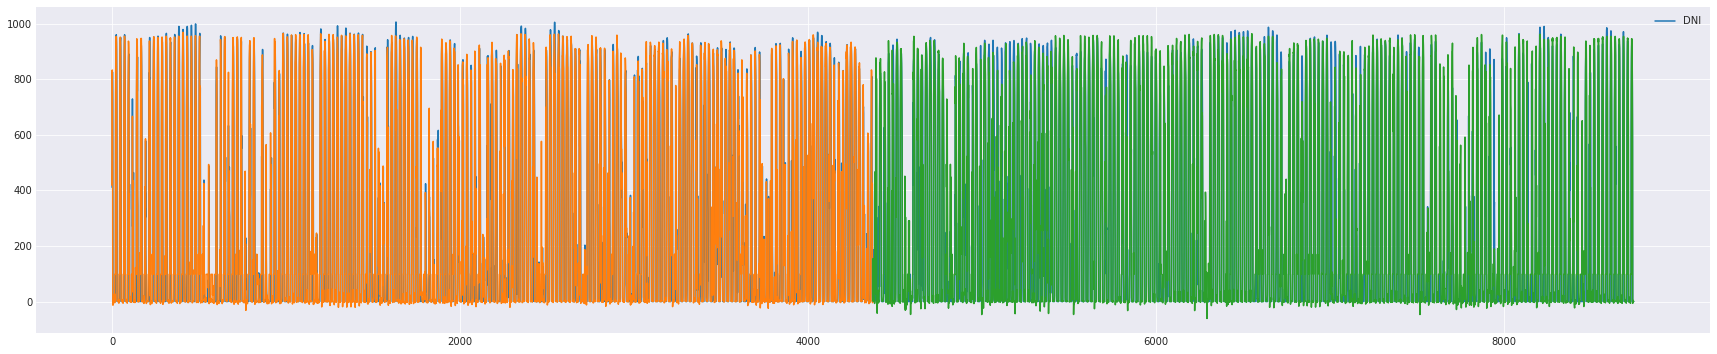

In [23]:
trainPredict = model.predict(X_train,batch_size=batch_size)
model.reset_states()
testPredict = model.predict(X_test,batch_size=batch_size)
model.reset_states()

plt.figure(figsize = (30,6))

plot_x1 = np.arange(0,len(y))
plt.plot(plot_x1, y)

# plt.plot(plot_x1-1, np.append(trainPredict,testPredict))

plt.plot(plot_x1[:len(y_train)]-1, trainPredict.ravel())

plt.plot(plot_x1[len(y_test):], testPredict.ravel())

plt.legend()
plt.show()
plt.savefig('../keras_models/LSTM_100x2flat_lag12_batch336.png')